# CREA-CI historical phenotypic wheat data analysis

## Load packages and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Tue Nov 14 13:38:38 2023


In [2]:
data_file <- "CREA-historic.xlsx"
experiments <- read_xlsx(data_file, sheet = "Experiment") |> rename_with(~tolower(gsub(" ", "_", .x)))
observations <- read_xlsx(data_file, sheet = "Observed scores") |> rename_with(~tolower(gsub(" ", "_", .x)))
glimpse(observations)

Rows: 7,979
Columns: 15
$ experiment_id            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ instcode                 <chr> "ITA383", "ITA383", "ITA383", "ITA383", "ITA3…
$ genus                    <chr> "Triticum", "Triticum", "Triticum", "Triticum…
$ accenumb                 <chr> "TA00004", "TA00018", "TA00025", "TA00087", "…
$ agent_id                 <chr> "AW_08340", "AW_08341", "AW_08342", "AW_08343…
$ doi                      <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ days_to_heading          <dbl> 125, 131, 123, 127, 125, 125, 130, 128, 126, …
$ plant_height             <dbl> 68, 108, 118, 114, 111, 117, 82, 65, 78, 82, …
$ thousand_kernel_weight   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ powdery_mildew           <dbl> 0, 2, 2, 2, 0, 2, 7, 0, 0, 0, 2, 0, 2, 7, 0, …
$ leaf_rust                <dbl> 0, 4, 2, 2, 2, 4, 2, 0, 0, 0, 0, 7, 4, 4, 2, …
$ yellow_rust              <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ septoria_triti

In [3]:
CREA_wheat <- observations |>
                left_join(experiments, by = "experiment_id") |>
                unite("campaign", c(year_start,year_end), sep="-") |>
                select(accenumb, campaign, days_to_heading:sds_sedimentation_volume) |>
                drop_na(accenumb, campaign) |> distinct() |> arrange(campaign, accenumb)
write_csv(CREA_wheat, "CREA_wheat.csv")
glimpse(CREA_wheat)

Rows: 7,947
Columns: 11
$ accenumb                 <chr> "TA00001", "TA00001", "TA00001", "TA00001", "…
$ campaign                 <chr> "2005-2006", "2005-2006", "2005-2006", "2005-…
$ days_to_heading          <dbl> 128, 127, 127, 127, 127, 126, 125, 122, 129, …
$ plant_height             <dbl> 74, 84, 78, 80, 66, 68, 68, 92, 85, 116, 80, …
$ thousand_kernel_weight   <dbl> 47.5, 45.8, 46.1, 47.2, 49.3, NA, NA, NA, NA,…
$ powdery_mildew           <dbl> 3, 5, 3, 5, 3, 0, 0, 2, 0, 0, 2, 4, 0, 0, 0, …
$ leaf_rust                <dbl> 3, 3, 1, 3, 3, 0, 0, 2, 4, 2, 0, 4, 2, 2, 0, …
$ yellow_rust              <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ septoria_tritici_ssp     <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ protein_content          <dbl> 11.1, 11.2, 10.9, 11.9, 10.6, NA, NA, NA, NA,…
$ sds_sedimentation_volume <dbl> 43, 43, 40, 42, 36, NA, NA, NA, NA, NA, NA, N…


In [4]:
data_total <- CREA_wheat
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat(sprintf("%i observations \n%i genotypes \n%i campaigns \n\nSummary of AGENT traits values:",
            nrow(data_total), nrow(genotypes), nrow(distinct(data_total["campaign"]))))
summary(data_total[3:11])

7947 observations 
1473 genotypes 
15 campaigns 

Summary of AGENT traits values:

 days_to_heading  plant_height    thousand_kernel_weight powdery_mildew
 Min.   : 89.0   Min.   :  0.00   Min.   :11.00          Min.   :0.00  
 1st Qu.:118.0   1st Qu.: 76.00   1st Qu.:38.50          1st Qu.:0.00  
 Median :124.0   Median : 92.00   Median :44.00          Median :0.00  
 Mean   :125.1   Mean   : 96.27   Mean   :43.67          Mean   :1.71  
 3rd Qu.:130.0   3rd Qu.:114.00   3rd Qu.:49.50          3rd Qu.:3.00  
 Max.   :226.0   Max.   :406.00   Max.   :83.80          Max.   :9.00  
 NA's   :14      NA's   :53       NA's   :4608           NA's   :4164  
   leaf_rust     yellow_rust     septoria_tritici_ssp protein_content
 Min.   :0.000   Mode :logical   Min.   :0.000        Min.   : 9.6   
 1st Qu.:0.000   FALSE:137       1st Qu.:0.000        1st Qu.:13.3   
 Median :2.000   TRUE :542       Median :2.000        Median :14.7   
 Mean   :2.542   NA's :7268      Mean   :2.288        Mean   :14.8   
 3rd Qu.:4.000                   3rd Qu.:4.000        3rd Qu.:16.2   
 Max

## Subset data, remove missing values and singletons, make factors

In [5]:
make_data_sub <- function(full_df, trait){
                    data_sub <- full_df |> select("accenumb", "campaign", all_of(trait)) |> drop_na() |> distinct() |>
                    group_by(accenumb) |> filter(n()>1) |> group_by(campaign) |> filter(n()>1) |> 
                    mutate_at(vars(accenumb, campaign), factor)
                    cat(nrow(data_sub), trait, "rows kept\n") 
                    return(as.data.frame(data_sub))}

data_sub_HT <- data_total |> make_data_sub("days_to_heading")
data_sub_PH <- data_total |> make_data_sub("plant_height")
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight")
data_sub_PM <- data_total |> make_data_sub("powdery_mildew")
data_sub_LR<- data_total |> make_data_sub("leaf_rust")
# YR has observations in only one campaign so cannot be analysed here
data_sub_ST <- data_total |> make_data_sub("septoria_tritici_ssp")
data_sub_PC <- data_total |> make_data_sub("protein_content")
data_sub_SV <- data_total |> make_data_sub("sds_sedimentation_volume")

7237 days_to_heading rows kept
7591 plant_height rows kept
3131 thousand_kernel_weight rows kept
2687 powdery_mildew rows kept
3186 leaf_rust rows kept
1729 septoria_tritici_ssp rows kept
2075 protein_content rows kept
2029 sds_sedimentation_volume rows kept


## Visualise trait values 

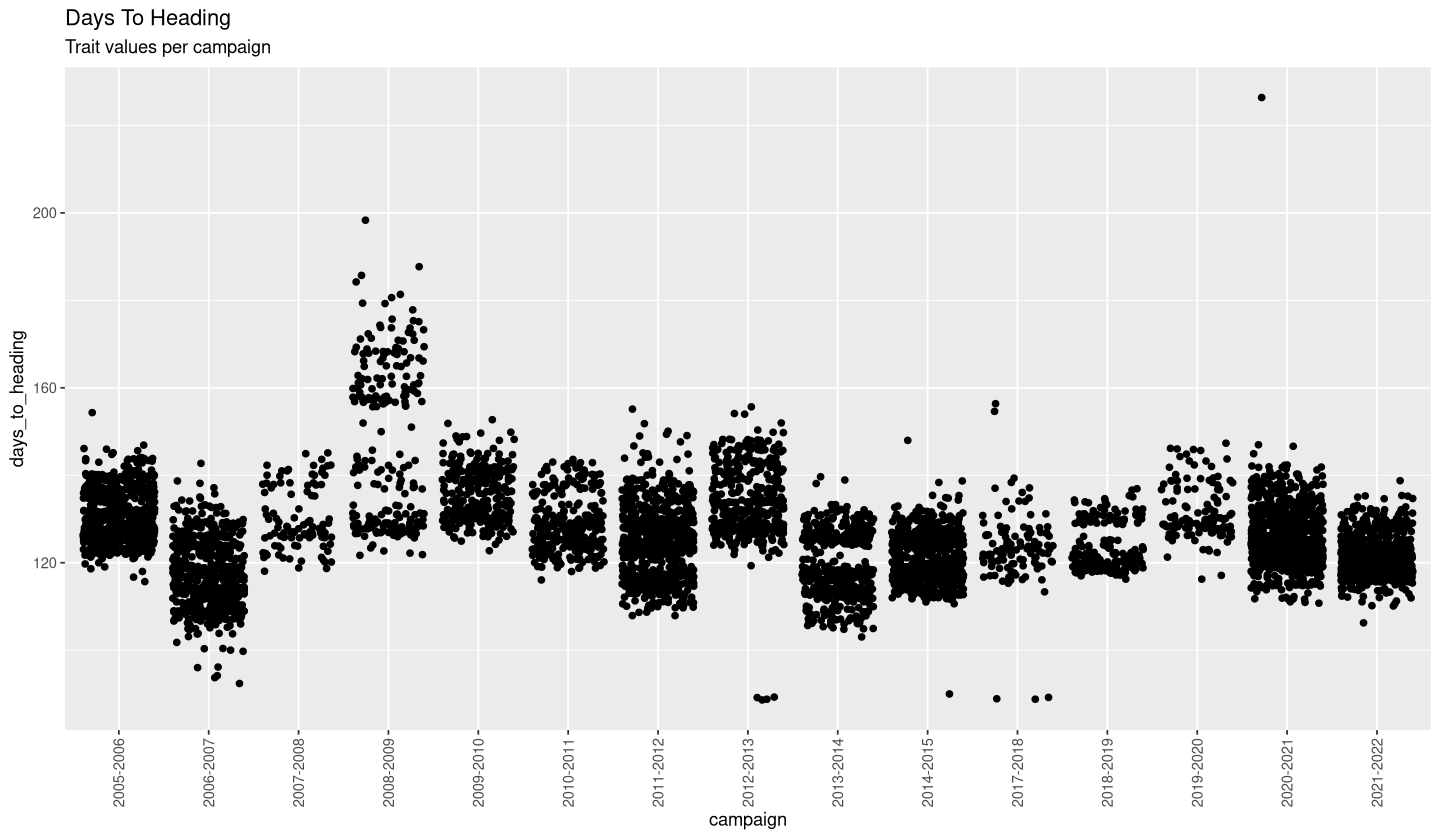

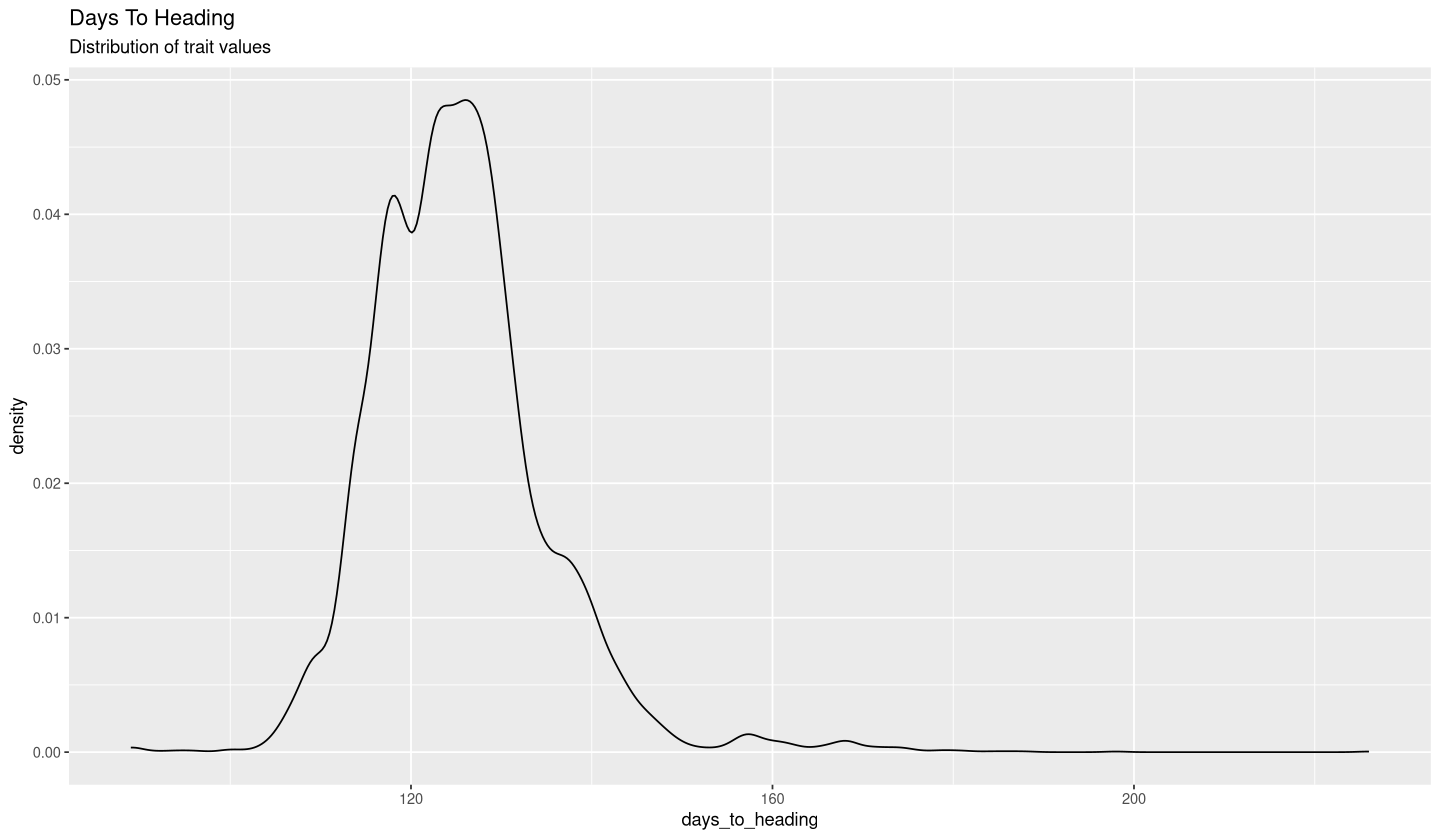

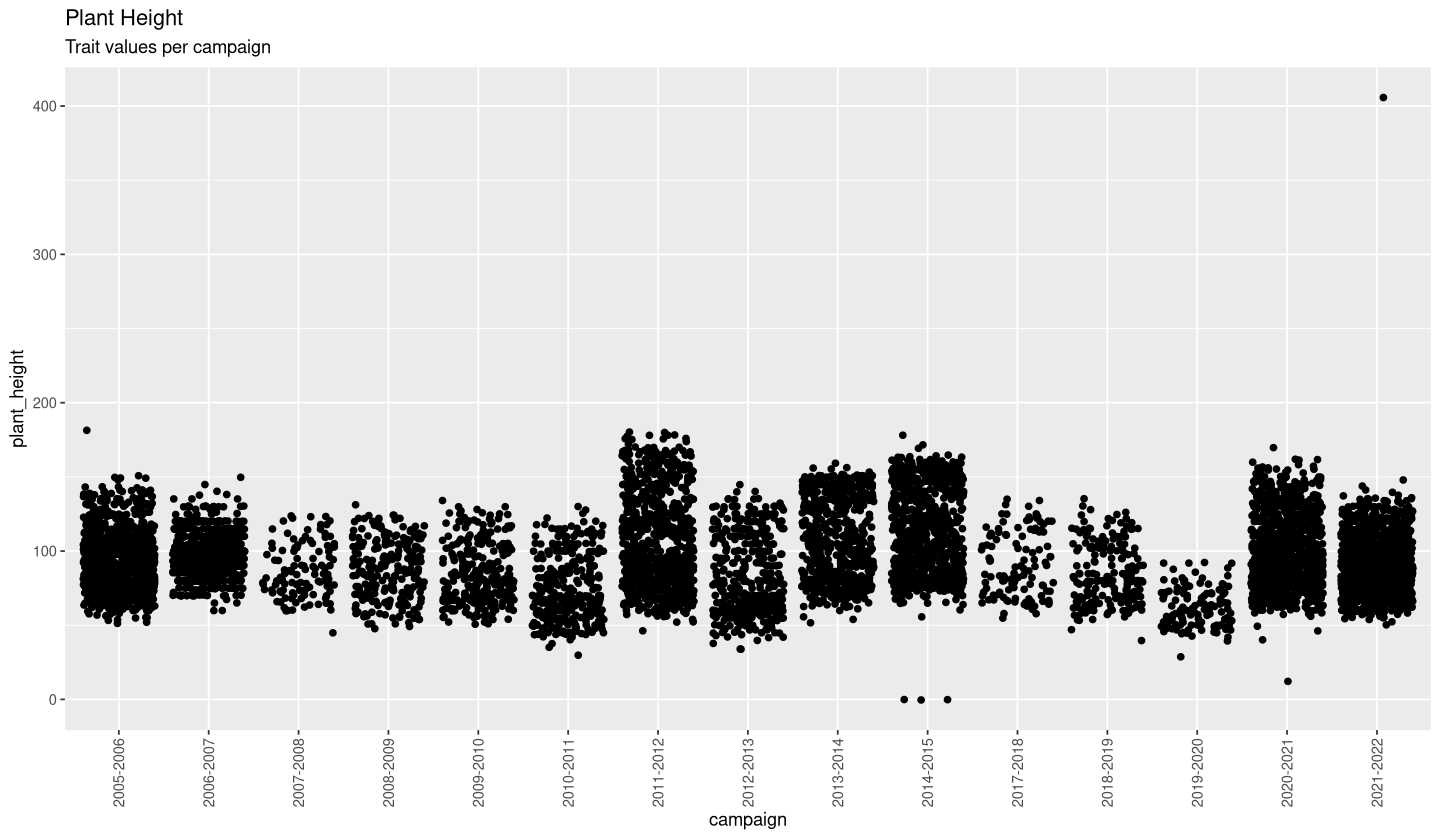

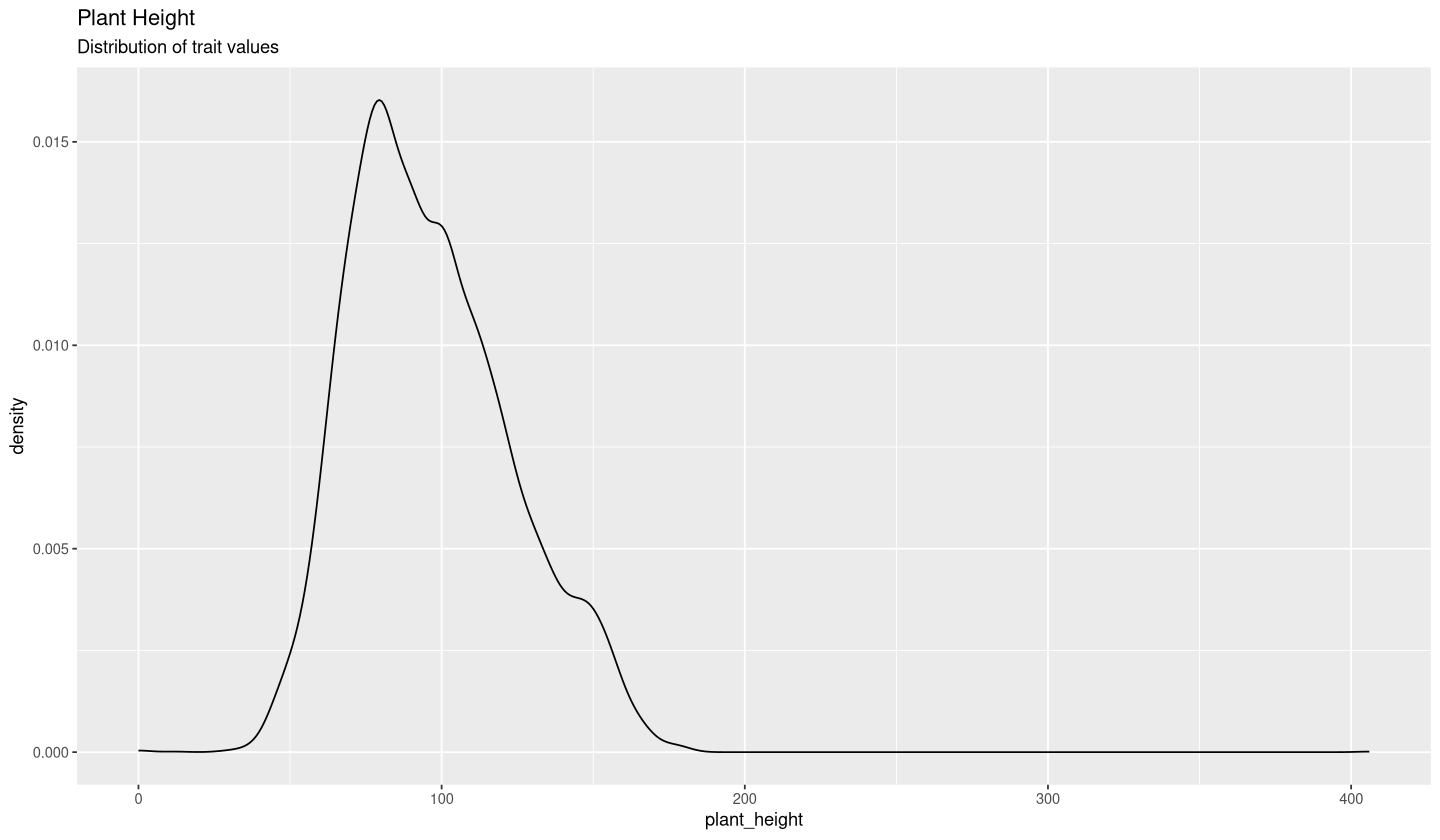

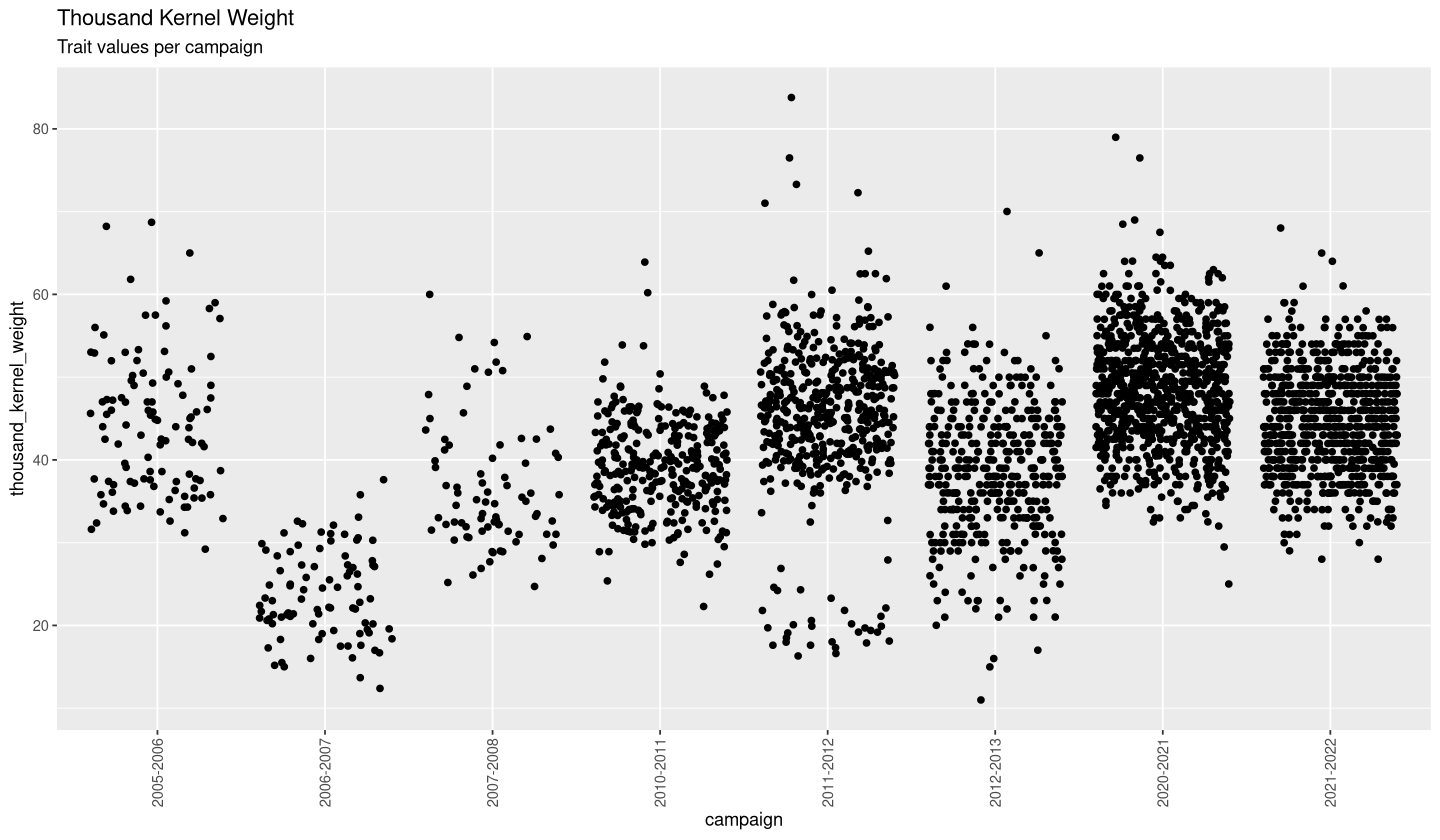

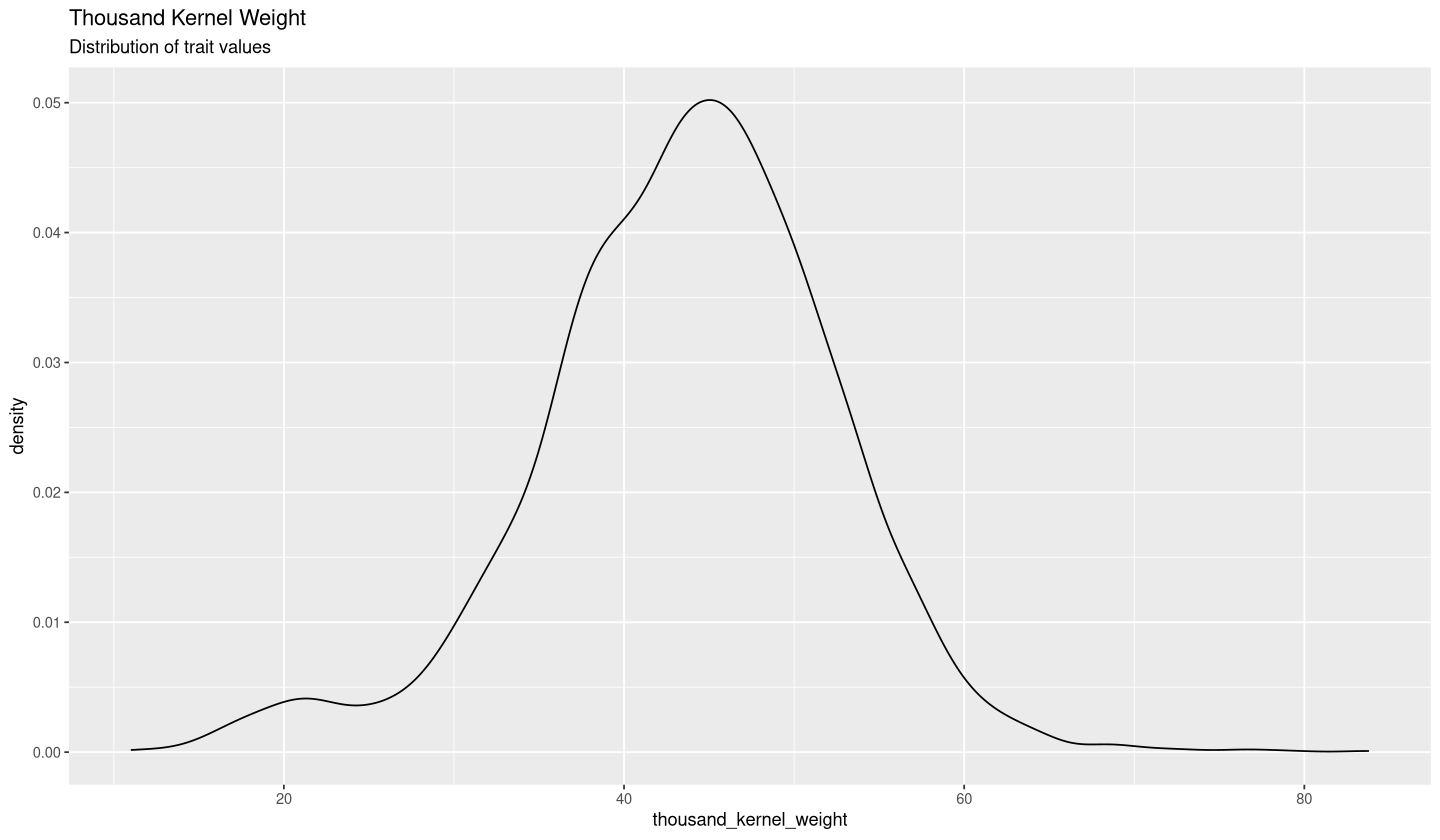

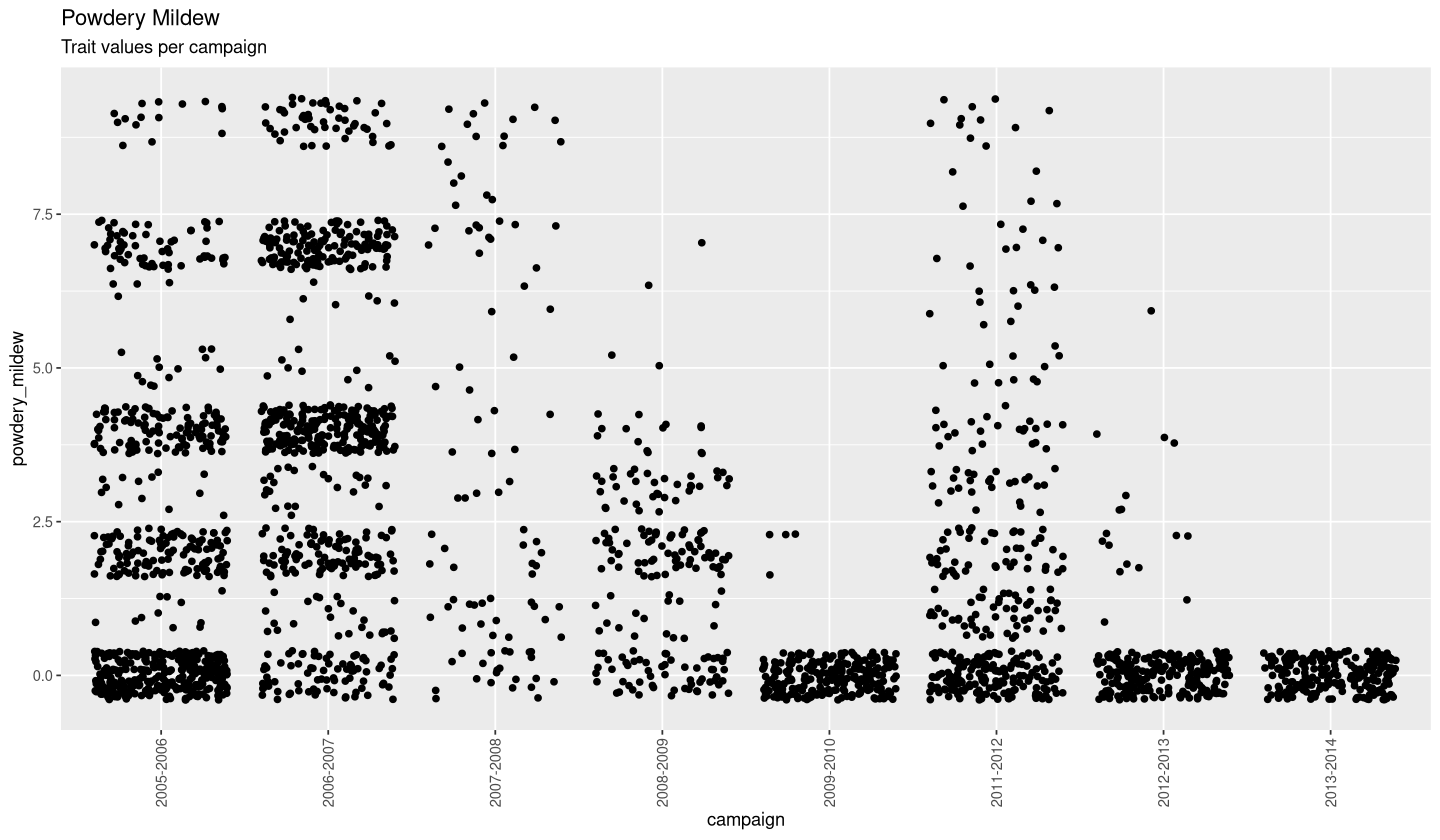

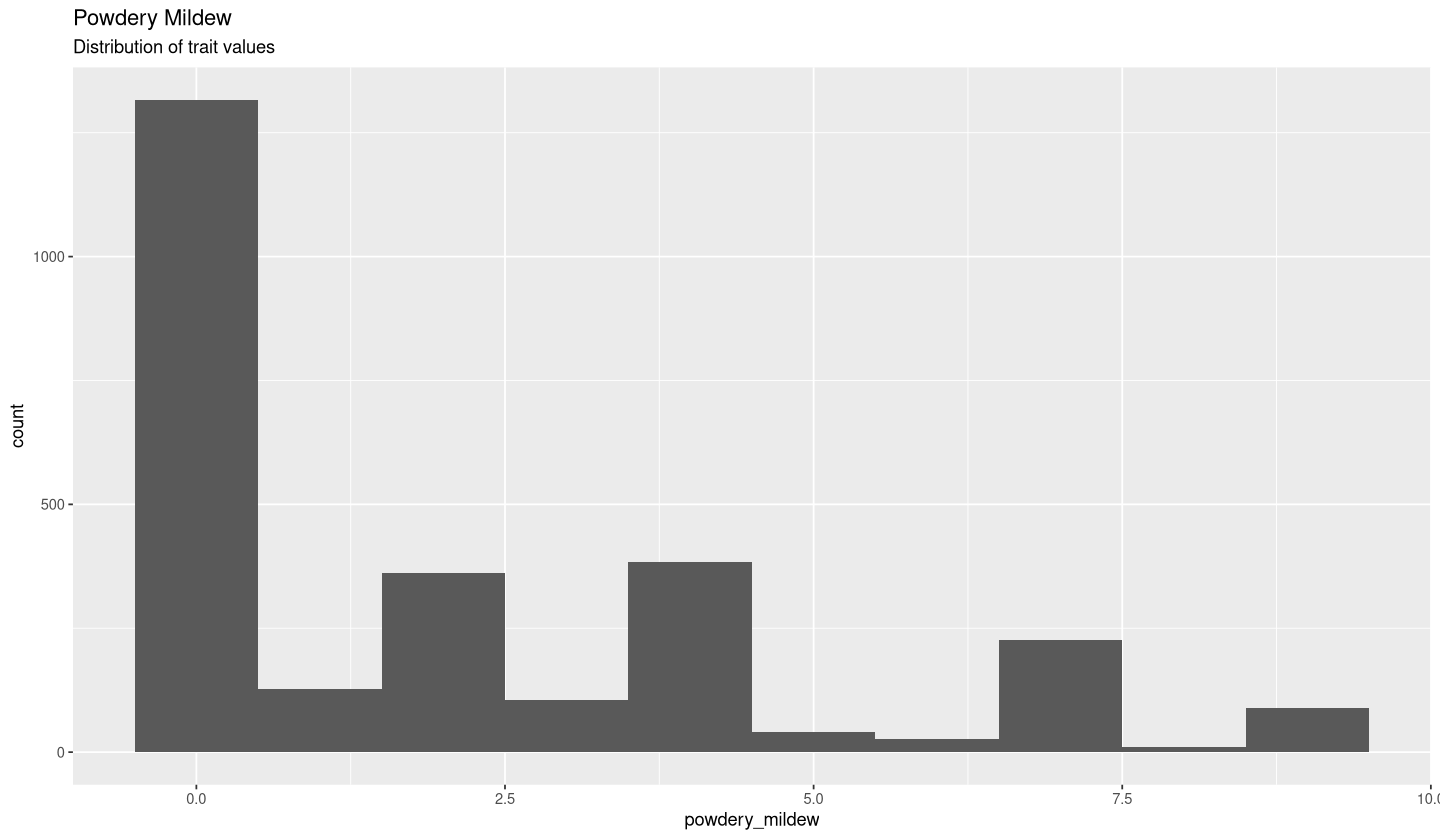

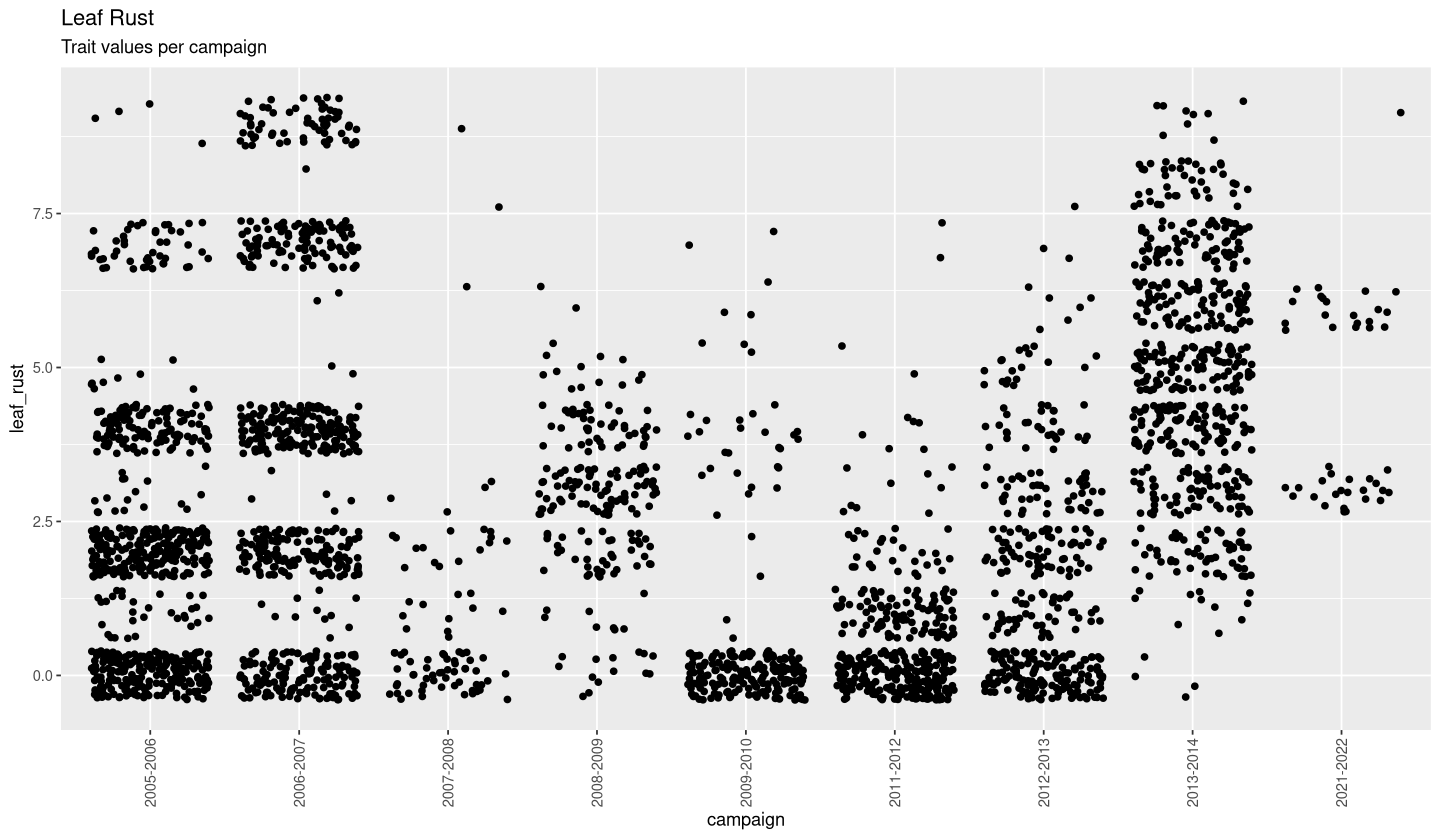

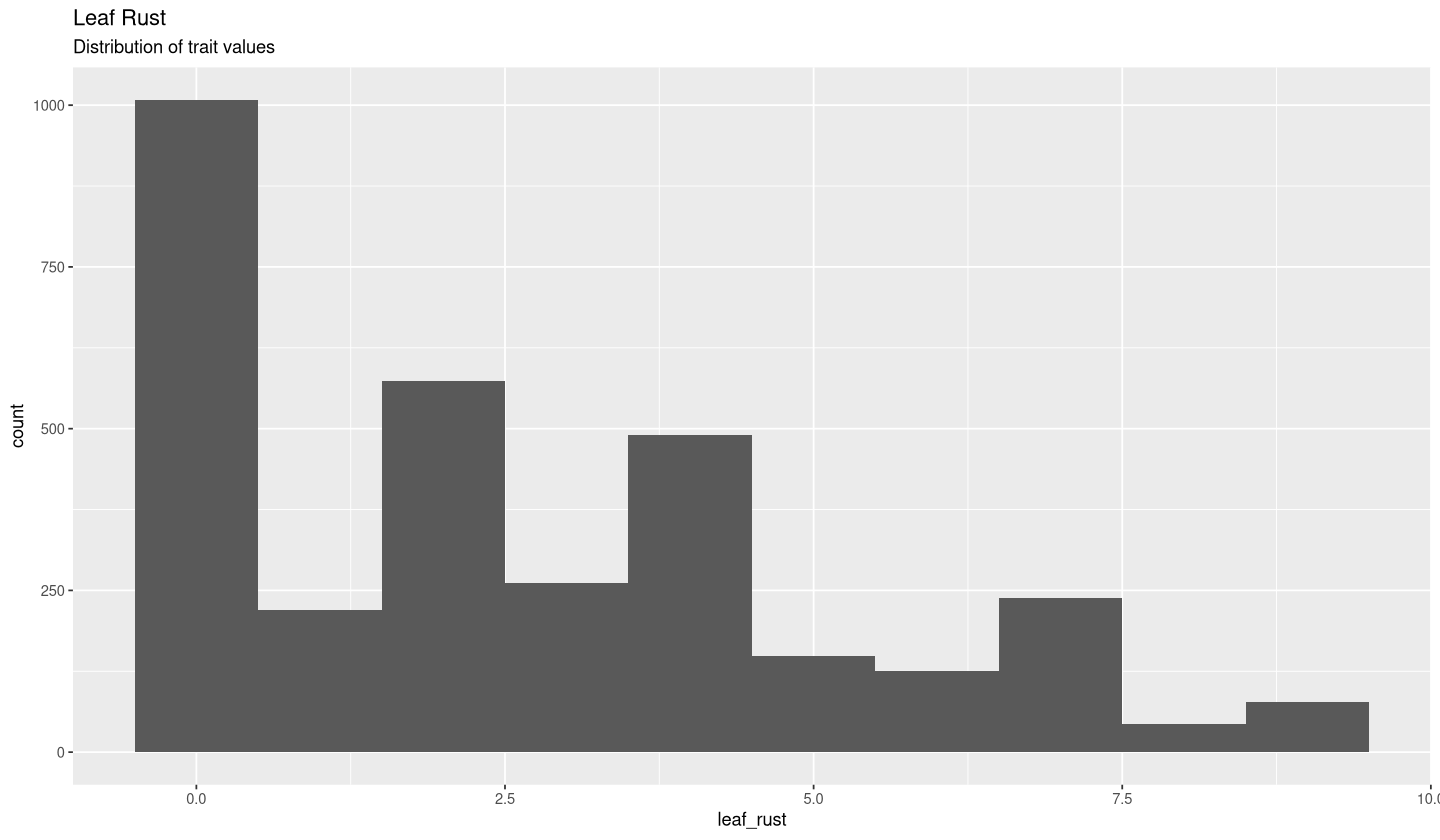

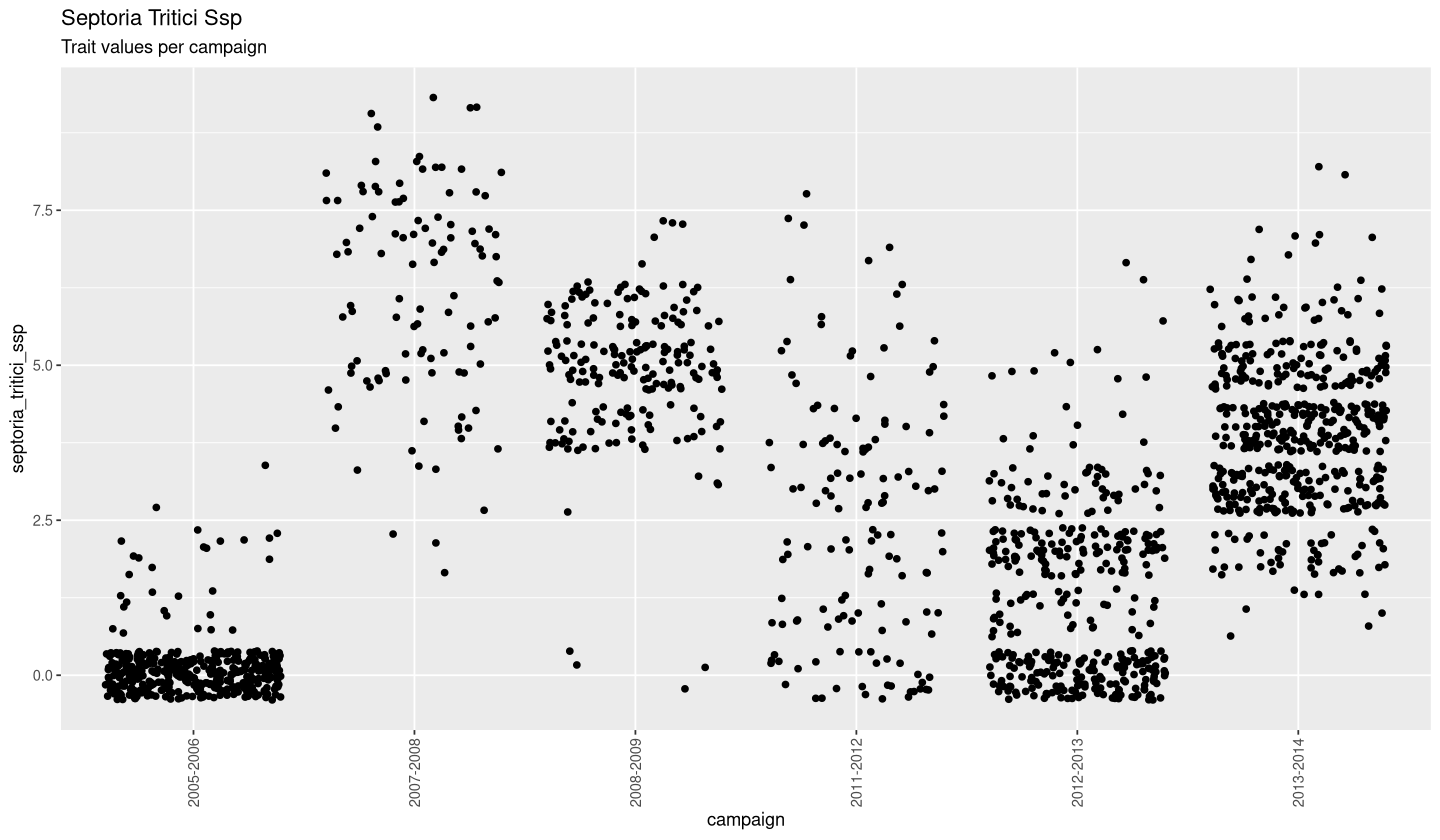

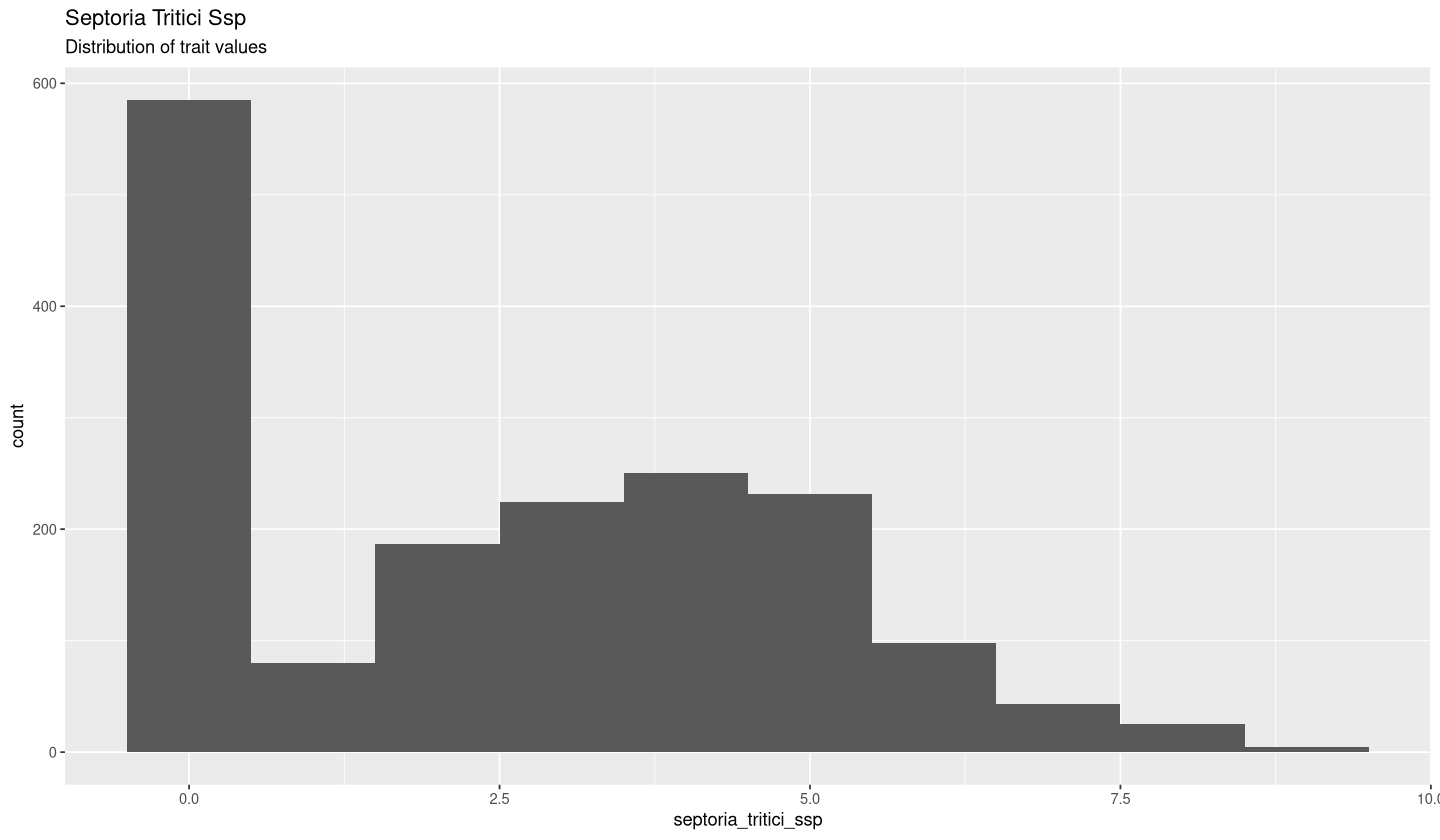

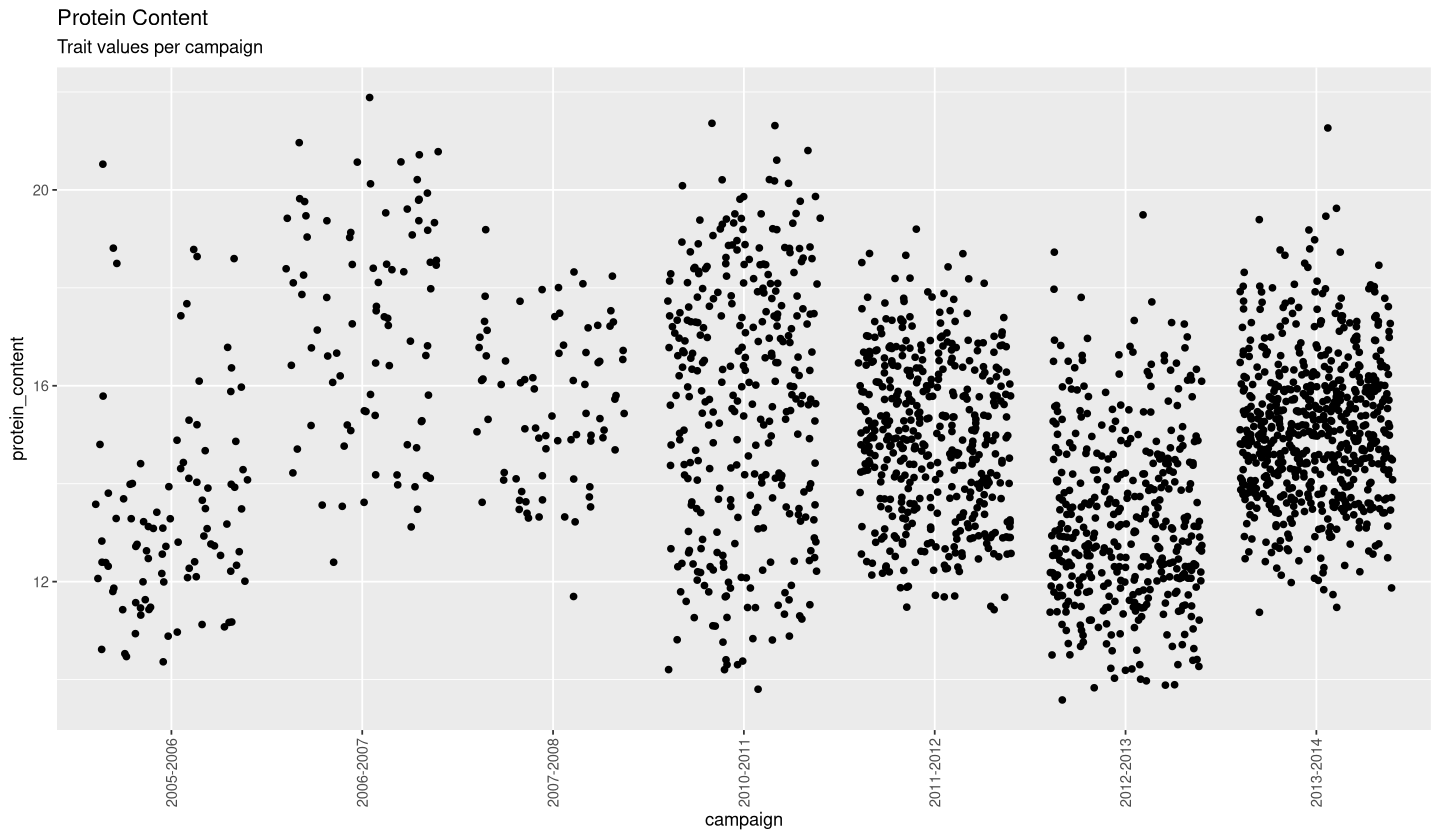

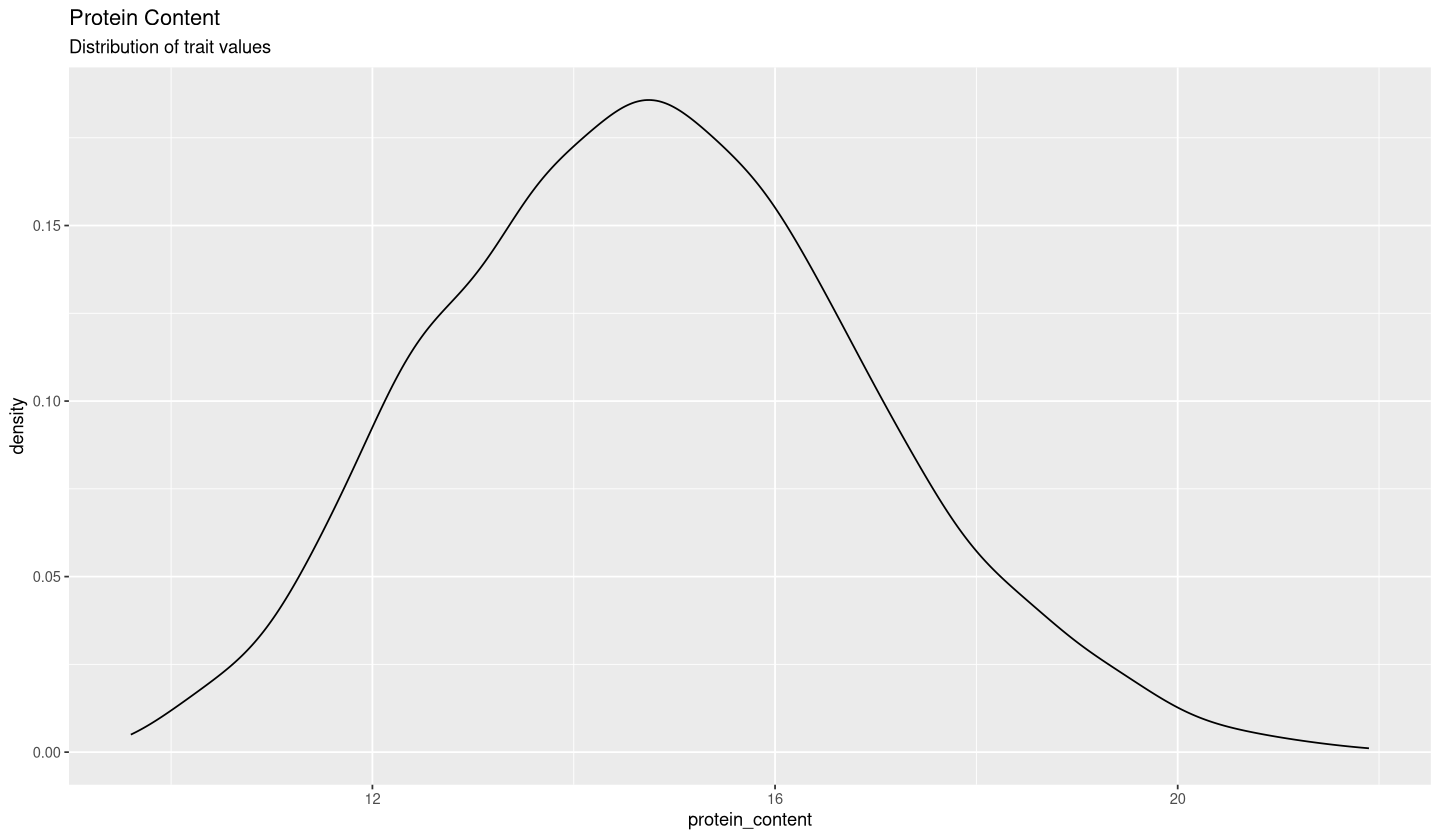

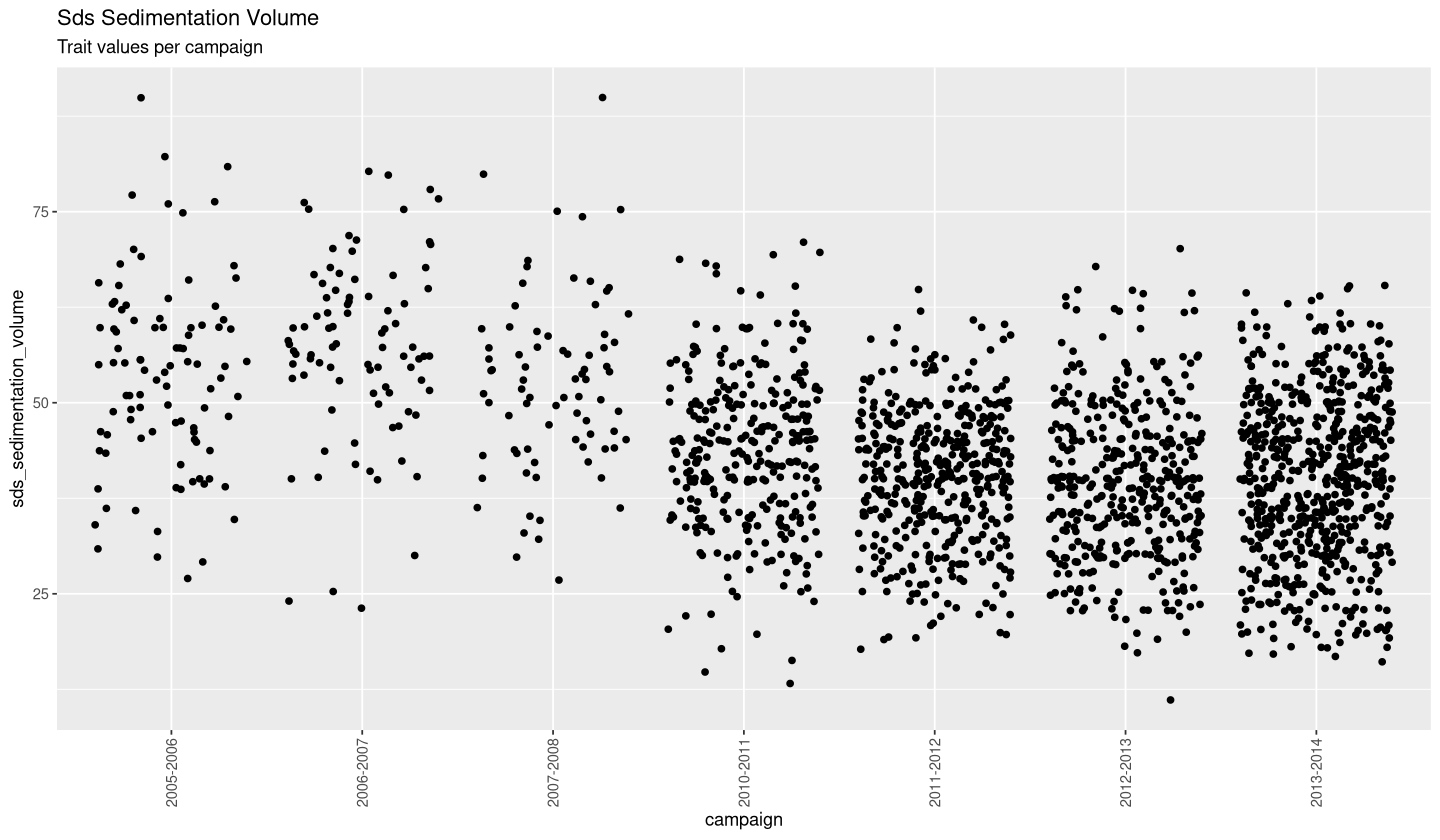

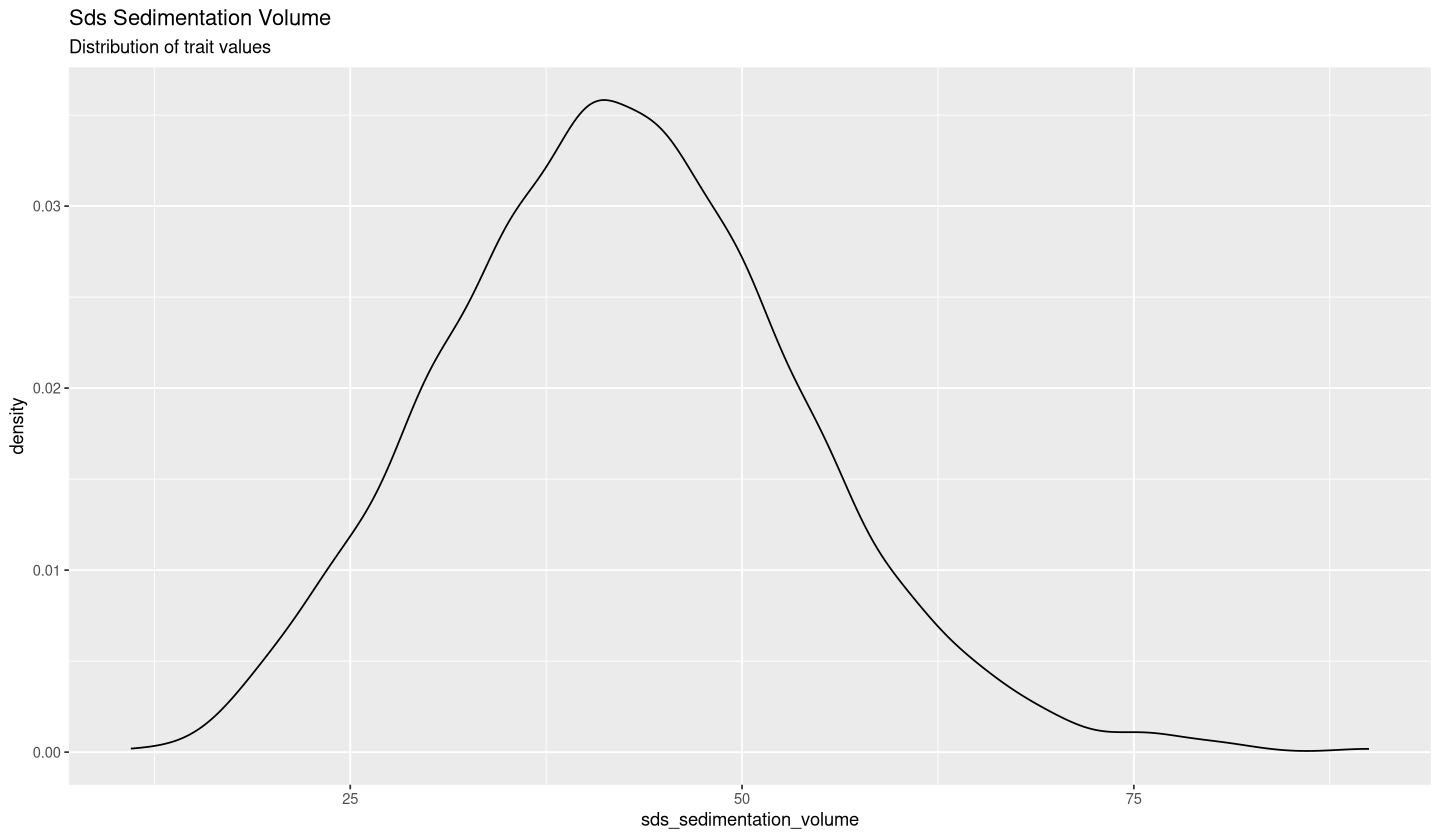

In [6]:
options(repr.plot.width=12, repr.plot.height=7)
visualise_trait <- function(data_sub, geom){
                    trait <- colnames(data_sub)[3]
                    trait_title <- trait |> str_replace_all("_", " ") |> str_to_title()
                    plot(ggplot(data_sub, aes(campaign,.data[[trait]])) + geom_jitter()
                         + theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=0.5))
                         + labs(title = trait_title, subtitle = "Trait values per campaign",))
                    plot(ggplot(data_sub, aes(.data[[trait]])) + geom
                         + labs(title = trait_title, subtitle = "Distribution of trait values",))}

data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())
data_sub_PM |> visualise_trait(geom_histogram(bins=10))
data_sub_LR |> visualise_trait(geom_histogram(bins=10))
data_sub_ST |> visualise_trait(geom_histogram(bins=10))
data_sub_PC |> visualise_trait(geom_density())
data_sub_SV |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [7]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

Online License checked out Tue Nov 14 13:38:44 2023
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -15916.48           1.0   7222 13:38:44    0.0
 2     -15337.52           1.0   7222 13:38:44    0.0
 3     -14955.02           1.0   7222 13:38:44    0.0
 4     -14783.94           1.0   7222 13:38:44    0.0
 5     -14722.89           1.0   7222 13:38:44    0.0
 6     -14716.41           1.0   7222 13:38:44    0.0
 7     -14716.15           1.0   7222 13:38:44    0.0
 8     -14716.14           1.0   7222 13:38:44    0.0
 9     -14716.14           1.0   7222 13:38:44    0.0


In [8]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -26320.82           1.0   7576 13:38:44    0.0
 2     -25509.43           1.0   7576 13:38:44    0.0
 3     -24620.76           1.0   7576 13:38:44    0.0
 4     -24179.50           1.0   7576 13:38:44    0.0
 5     -23976.32           1.0   7576 13:38:44    0.0
 6     -23939.33           1.0   7576 13:38:44    0.0
 7     -23936.84           1.0   7576 13:38:44    0.0
 8     -23936.79           1.0   7576 13:38:44    0.0
 9     -23936.79           1.0   7576 13:38:44    0.0


In [9]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -7495.663           1.0   3123 13:38:44    0.0
 2     -7316.967           1.0   3123 13:38:44    0.0
 3     -7128.489           1.0   3123 13:38:44    0.0
 4     -7022.295           1.0   3123 13:38:44    0.0
 5     -6989.322           1.0   3123 13:38:44    0.0
 6     -6986.760           1.0   3123 13:38:44    0.0
 7     -6986.698           1.0   3123 13:38:44    0.0
 8     -6986.696           1.0   3123 13:38:44    0.0


In [10]:
data_sub_PM <- data_sub_PM |> filter(campaign != "2013-2014") # this campaign has all PM values equal to zero and is excluded to enable fitting the model. 
asreml_campaign_PM <- asreml(fixed = powdery_mildew ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PM)


Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2918.696           1.0   2454 13:38:44    0.0 (1 restrained)
 2     -2789.100           1.0   2454 13:38:44    0.0 (1 restrained)
 3     -2662.034           1.0   2454 13:38:44    0.0 (1 restrained)
 4     -2623.163           1.0   2454 13:38:44    0.0 (1 restrained)
 5     -2616.404           1.0   2454 13:38:44    0.0 (1 restrained)
 6     -2616.335           1.0   2454 13:38:44    0.0
 7     -2616.334           1.0   2454 13:38:44    0.0


In [11]:
asreml_campaign_LR <- asreml(fixed = leaf_rust ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_LR)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3772.500           1.0   3177 13:38:44    0.0
 2     -3662.862           1.0   3177 13:38:44    0.0
 3     -3564.159           1.0   3177 13:38:44    0.0
 4     -3524.821           1.0   3177 13:38:44    0.0
 5     -3518.426           1.0   3177 13:38:44    0.0
 6     -3518.377           1.0   3177 13:38:44    0.0
 7     -3518.377           1.0   3177 13:38:44    0.0


In [12]:
asreml_campaign_ST <- asreml(fixed = septoria_tritici_ssp ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_ST)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1135.272           1.0   1723 13:38:44    0.0
 2     -1030.493           1.0   1723 13:38:44    0.0
 3      -951.267           1.0   1723 13:38:44    0.0
 4      -920.686           1.0   1723 13:38:44    0.0
 5      -915.038           1.0   1723 13:38:44    0.0
 6      -914.961           1.0   1723 13:38:44    0.0
 7      -914.961           1.0   1723 13:38:44    0.0


In [13]:
asreml_campaign_PC <- asreml(fixed = protein_content ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PC)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2132.592           1.0   2068 13:38:44    0.0
 2     -2064.898           1.0   2068 13:38:44    0.0
 3     -1997.975           1.0   2068 13:38:44    0.0
 4     -1963.092           1.0   2068 13:38:44    0.0
 5     -1952.519           1.0   2068 13:38:44    0.0
 6     -1951.739           1.0   2068 13:38:44    0.0
 7     -1951.721           1.0   2068 13:38:44    0.0
 8     -1951.721           1.0   2068 13:38:44    0.0


In [14]:
asreml_campaign_SV <- asreml(fixed = sds_sedimentation_volume ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SV)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:44 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -5461.731           1.0   2022 13:38:44    0.0
 2     -5332.707           1.0   2022 13:38:44    0.0
 3     -5199.762           1.0   2022 13:38:44    0.0
 4     -5120.407           1.0   2022 13:38:44    0.0
 5     -5085.823           1.0   2022 13:38:44    0.0
 6     -5079.894           1.0   2022 13:38:44    0.0
 7     -5079.557           1.0   2022 13:38:44    0.0
 8     -5079.552           1.0   2022 13:38:44    0.0


In [15]:
get_campaign_effect <- function(asreml_campaign){
                        intercept_index <- nrow(asreml_campaign$coeff$fixed)
                        intercept <- asreml_campaign$coeff$fixed[intercept_index]
                        campaign_effect <- asreml_campaign$coeff$fixed[-intercept_index,] + intercept
                        return(campaign_effect |> as.data.frame() |> rownames_to_column() |> 
                                mutate(campaign = str_sub(rowname,10)) |> 
                                select(campaign, campaign_effect))}

campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)
campaign_effect_PM <- get_campaign_effect(asreml_campaign_PM)
campaign_effect_LR <- get_campaign_effect(asreml_campaign_LR)
campaign_effect_ST <- get_campaign_effect(asreml_campaign_ST)
campaign_effect_PC <- get_campaign_effect(asreml_campaign_PC)
campaign_effect_SV <- get_campaign_effect(asreml_campaign_SV)

## Extract heterogeneous error variances

In [16]:
get_error_var <- function(asreml_campaign){
                    summary(asreml_campaign)$varcomp |> slice(2:n()) |> select(std.error) |> 
                    as_tibble() |> rename("error_variance"="std.error")}

error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_TKW <- get_error_var(asreml_campaign_TKW)
error_var_PM <- get_error_var(asreml_campaign_PM)
error_var_LR <- get_error_var(asreml_campaign_LR)
error_var_ST <- get_error_var(asreml_campaign_ST)
error_var_PC <- get_error_var(asreml_campaign_PC)
error_var_SV <- get_error_var(asreml_campaign_SV)

## Calculate and standardize the coefficient of variation (CV)

In [17]:
make_CV_df <- function(campaign_effect, error_var){
                tibble(campaign_effect, error_var) |> 
                mutate(coefficient_of_variation=sqrt(error_variance)/campaign_effect) |> 
                mutate(standardized_CV=scale(coefficient_of_variation)[,1])}

CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)
CV_df_PM <- make_CV_df(campaign_effect_PM, error_var_PM)
CV_df_LR <- make_CV_df(campaign_effect_LR, error_var_LR)
CV_df_ST <- make_CV_df(campaign_effect_ST, error_var_ST)
CV_df_PC <- make_CV_df(campaign_effect_PC, error_var_PC)
CV_df_SV <- make_CV_df(campaign_effect_SV, error_var_SV)

## Remove outlier campaigns

In [18]:
correct_I <- function(data_sub, CV_df){
                        outlier_campaigns <- CV_df |> filter(standardized_CV > 3.5) |> select(campaign)
                        cat(nrow(outlier_campaigns), "outlier campaign(s) detected for trait", colnames(data_sub)[3], "\n")
                        return(data_sub |> filter(! campaign %in% outlier_campaigns) |>
                               group_by(campaign) |> filter(n()>1) |> ungroup())}

data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)
data_corrected_PM_I <- data_sub_PM |> correct_I(CV_df_PM)
data_corrected_LR_I <- data_sub_LR |> correct_I(CV_df_LR)
data_corrected_ST_I <- data_sub_ST |> correct_I(CV_df_ST)
data_corrected_PC_I <- data_sub_PC |> correct_I(CV_df_PC)
data_corrected_SV_I <- data_sub_SV |> correct_I(CV_df_SV)

0 outlier campaign(s) detected for trait days_to_heading 
0 outlier campaign(s) detected for trait plant_height 
0 outlier campaign(s) detected for trait thousand_kernel_weight 
0 outlier campaign(s) detected for trait powdery_mildew 
0 outlier campaign(s) detected for trait leaf_rust 
0 outlier campaign(s) detected for trait septoria_tritici_ssp 
0 outlier campaign(s) detected for trait protein_content 
0 outlier campaign(s) detected for trait sds_sedimentation_volume 


## Residuals

In [19]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:45 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -12443.79           1.0   5890 13:38:46    0.8 (1 restrained)
 2     -11921.85           1.0   5890 13:38:46    0.5
 3     -11838.80           1.0   5890 13:38:47    0.5
 4     -11806.90           1.0   5890 13:38:47    0.5
 5     -11795.33           1.0   5890 13:38:48    0.5
 6     -11792.53           1.0   5890 13:38:48    0.5
 7     -11792.01           1.0   5890 13:38:49    0.5
 8     -11791.97           1.0   5890 13:38:49    0.5
 9     -11791.97           1.0   5890 13:38:50    0.5


In [20]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:50 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -20532.87           1.0   6245 13:38:51    0.8 (3 restrained)
 2     -19521.96           1.0   6245 13:38:51    0.5
 3     -19323.23           1.0   6245 13:38:52    0.5
 4     -19231.17           1.0   6245 13:38:52    0.5
 5     -19204.87           1.0   6245 13:38:53    0.5
 6     -19203.00           1.0   6245 13:38:53    0.5
 7     -19202.93           1.0   6245 13:38:54    0.5
 8     -19202.93           1.0   6245 13:38:54    0.5
 9     -19202.93           1.0   6245 13:38:55    0.5


In [21]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:55 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4883.565           1.0   2155 13:38:55    0.3
 2     -4829.927           1.0   2155 13:38:56    0.2
 3     -4796.029           1.0   2155 13:38:56    0.2
 4     -4784.328           1.0   2155 13:38:56    0.2
 5     -4779.644           1.0   2155 13:38:56    0.2
 6     -4778.363           1.0   2155 13:38:56    0.2
 7     -4778.117           1.0   2155 13:38:56    0.2
 8     -4778.100           1.0   2155 13:38:57    0.2
 9     -4778.100           1.0   2155 13:38:57    0.2


In [22]:
asreml_res_PM <- asreml(fixed = powdery_mildew ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PM_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:57 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2219.975           1.0   1490 13:38:57    0.3
 2     -2164.201           1.0   1490 13:38:57    0.2
 3     -2110.799           1.0   1490 13:38:58    0.2
 4     -2084.421           1.0   1490 13:38:58    0.2
 5     -2076.031           1.0   1490 13:38:58    0.2
 6     -2074.571           1.0   1490 13:38:58    0.2
 7     -2074.317           1.0   1490 13:38:58    0.2
 8     -2074.282           1.0   1490 13:38:59    0.2
 9     -2074.275           1.0   1490 13:38:59    0.2
10     -2074.274           1.0   1490 13:38:59    0.2
11     -2074.274           1.0   1490 13:38:59    0.2


In [23]:
asreml_res_LR <- asreml(fixed = leaf_rust ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_LR_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:38:59 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3118.273           1.0   2202 13:39:00    0.3
 2     -3023.464           1.0   2202 13:39:00    0.2
 3     -2933.285           1.0   2202 13:39:00    0.2
 4     -2890.363           1.0   2202 13:39:00    0.2
 5     -2879.032           1.0   2202 13:39:00    0.2
 6     -2878.126           1.0   2202 13:39:01    0.2
 7     -2878.062           1.0   2202 13:39:01    0.2
 8     -2878.061           1.0   2202 13:39:01    0.2


In [24]:
asreml_res_ST <- asreml(fixed = septoria_tritici_ssp ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_ST_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:01 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1292.813           1.0   1245 13:39:01    0.0
 2     -1208.938           1.0   1245 13:39:01    0.0
 3     -1128.704           1.0   1245 13:39:01    0.0
 4     -1090.132           1.0   1245 13:39:01    0.0
 5     -1079.177           1.0   1245 13:39:01    0.0
 6     -1077.185           1.0   1245 13:39:01    0.0
 7     -1076.652           1.0   1245 13:39:01    0.0
 8     -1076.573           1.0   1245 13:39:01    0.0
 9     -1076.570           1.0   1245 13:39:01    0.0


In [25]:
asreml_res_PC <- asreml(fixed = protein_content ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PC_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:01 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1840.412           1.0   1803 13:39:01    0.0
 2     -1815.109           1.0   1803 13:39:01    0.0
 3     -1791.337           1.0   1803 13:39:01    0.0
 4     -1780.268           1.0   1803 13:39:01    0.0
 5     -1777.054           1.0   1803 13:39:01    0.0
 6     -1776.588           1.0   1803 13:39:01    0.0
 7     -1776.542           1.0   1803 13:39:01    0.0
 8     -1776.541           1.0   1803 13:39:01    0.0


In [26]:
asreml_res_SV <- asreml(fixed = sds_sedimentation_volume ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SV_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:01 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4433.193           1.0   1756 13:39:01    0.0
 2     -4391.346           1.0   1756 13:39:01    0.0
 3     -4373.381           1.0   1756 13:39:01    0.0
 4     -4371.254           1.0   1756 13:39:02    0.0
 5     -4371.030           1.0   1756 13:39:02    0.0
 6     -4371.015           1.0   1756 13:39:02    0.0
 7     -4371.015           1.0   1756 13:39:02    0.0


300 outlier value(s) detected for trait Days To Heading63 outlier value(s) detected for trait Plant Height

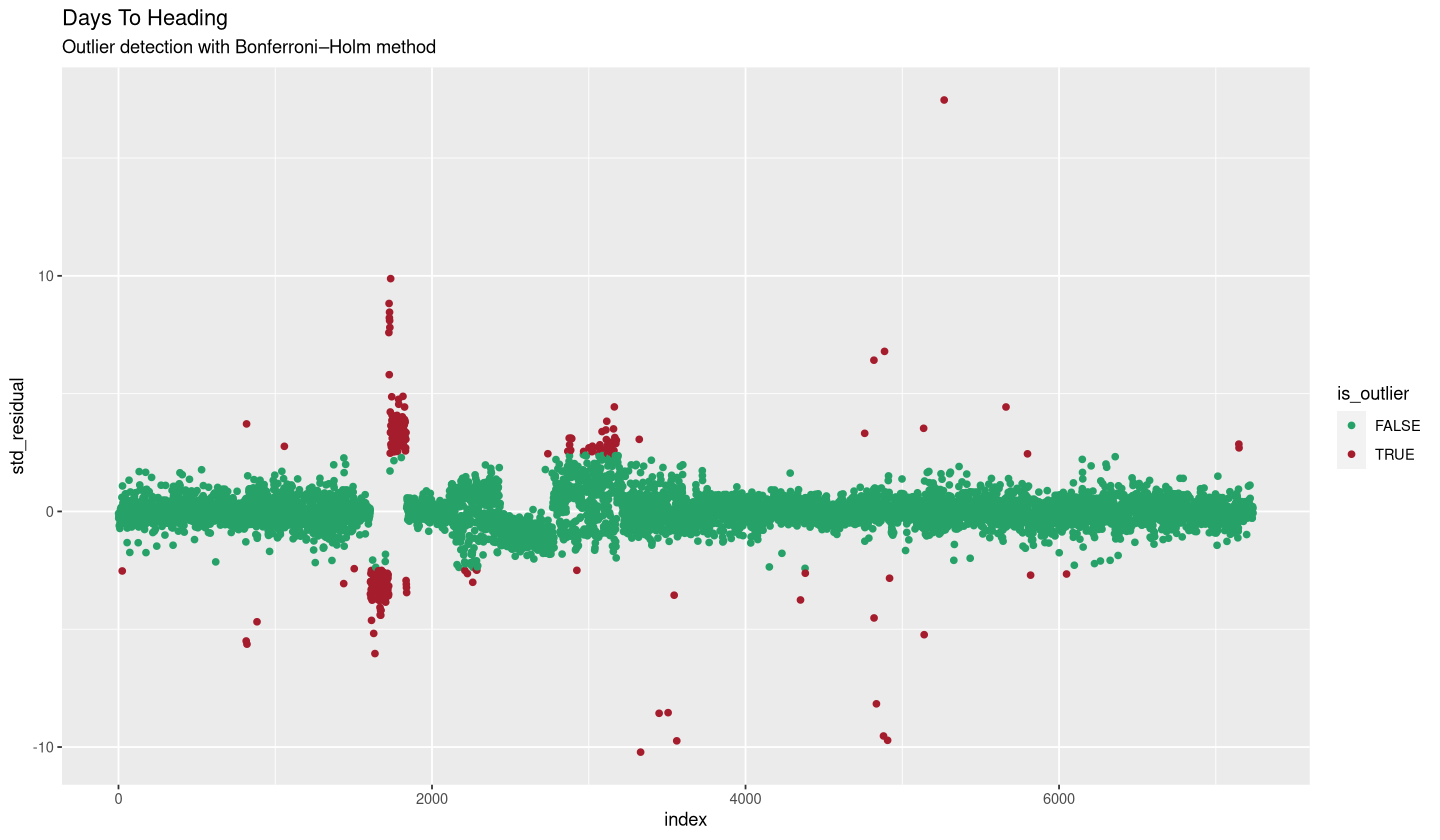

55 outlier value(s) detected for trait Thousand Kernel Weight

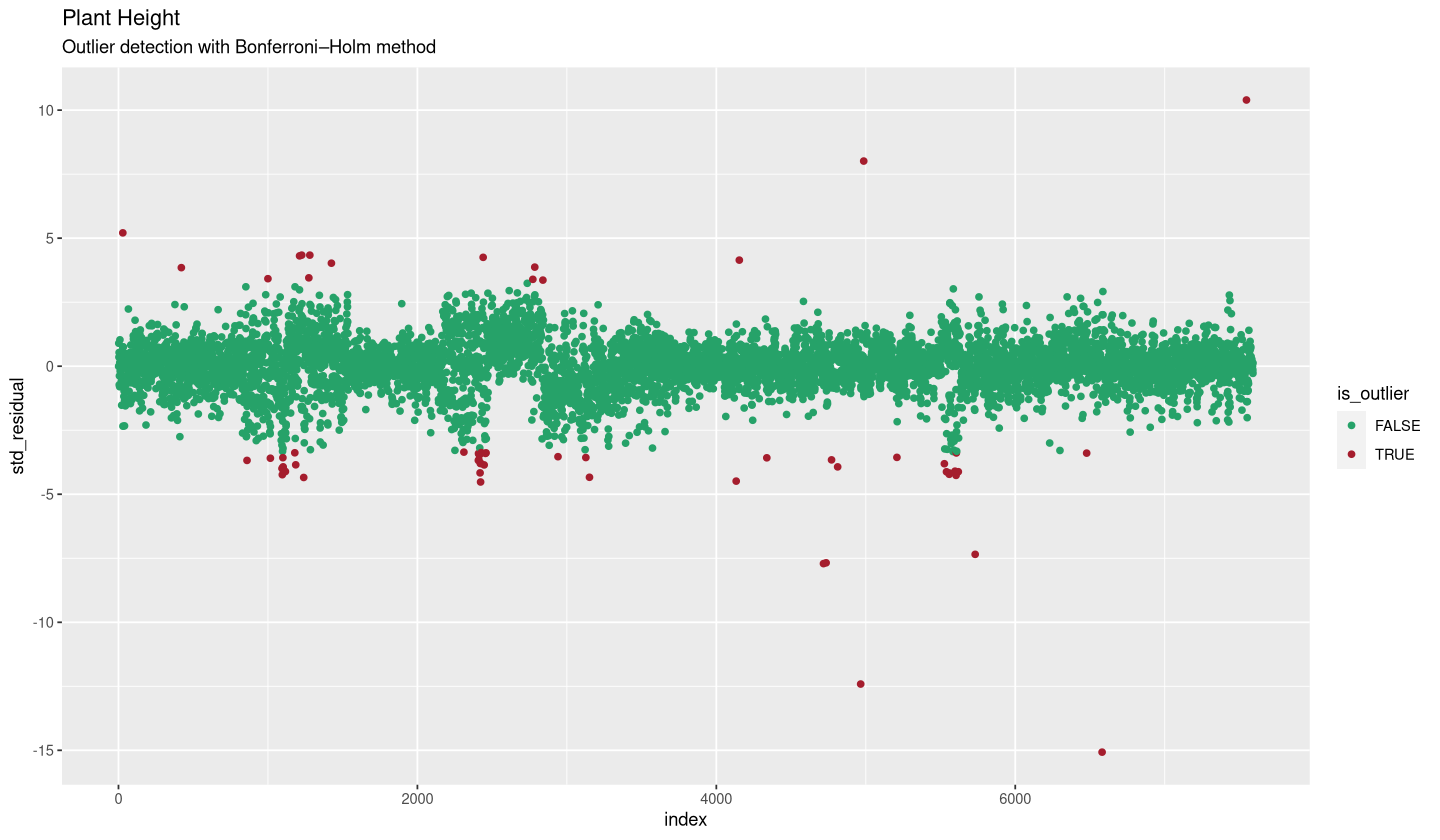

6 outlier value(s) detected for trait Powdery Mildew

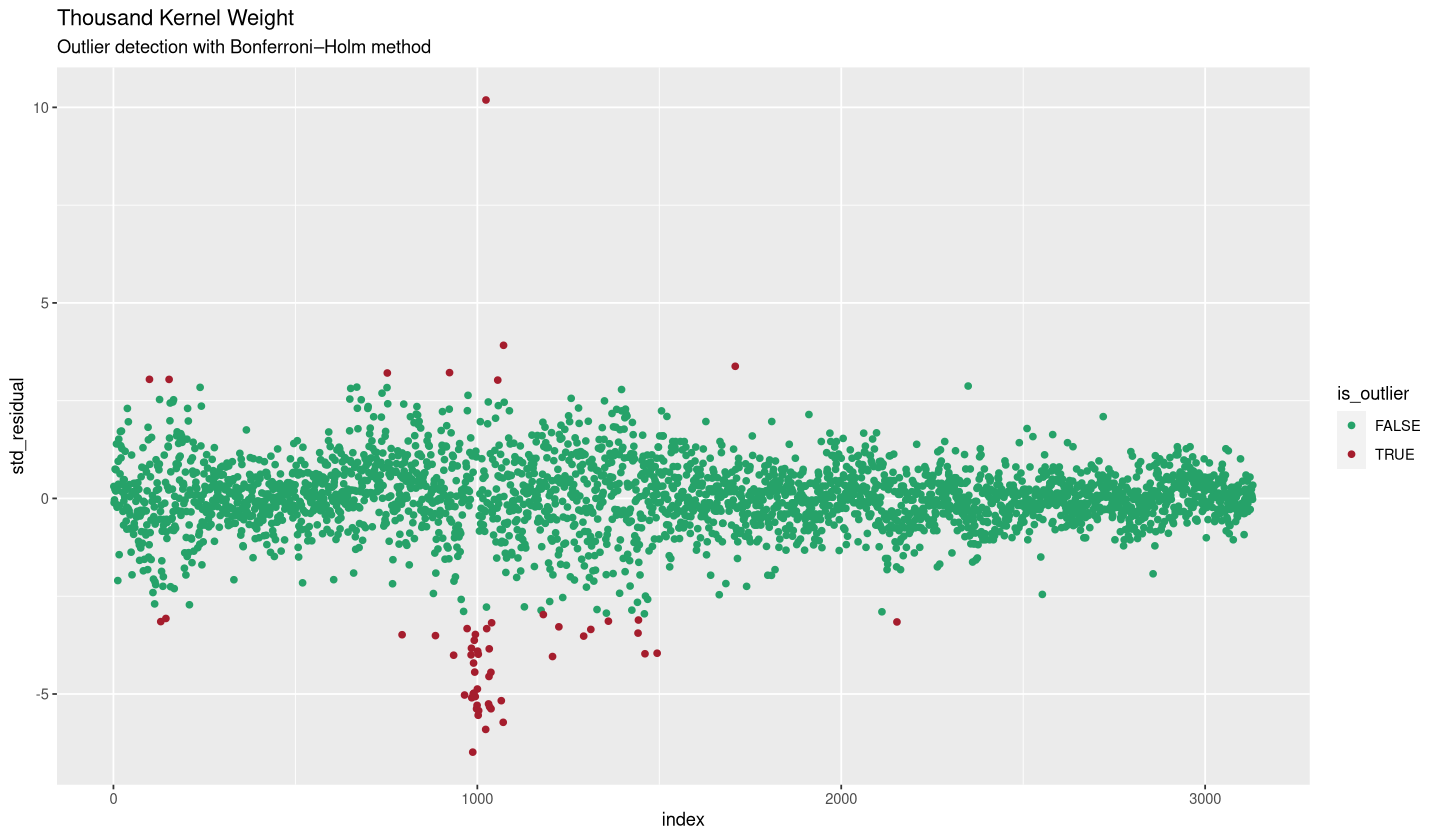

5 outlier value(s) detected for trait Leaf Rust

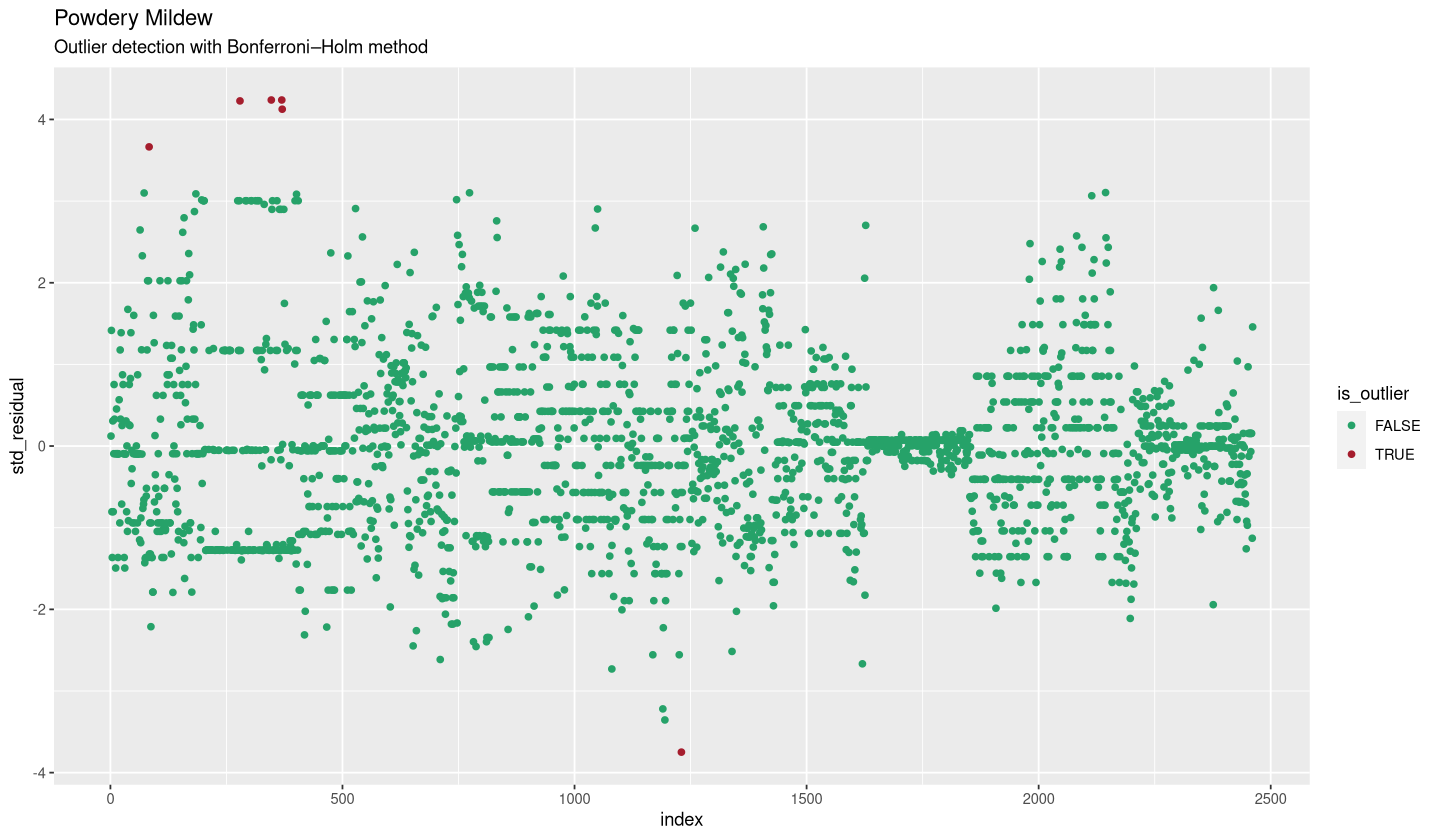

7 outlier value(s) detected for trait Septoria Tritici Ssp

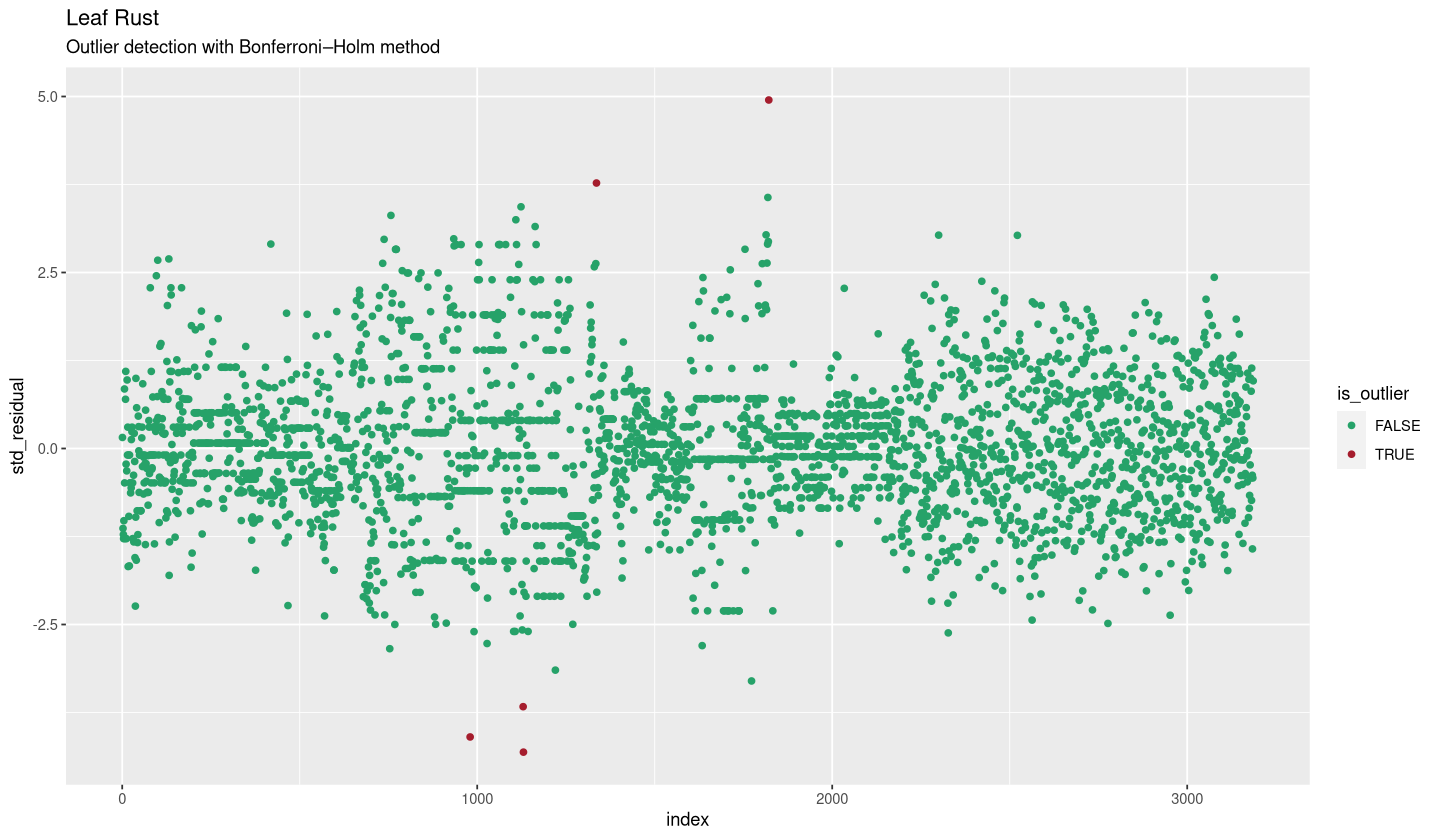

0 outlier value(s) detected for trait Protein Content

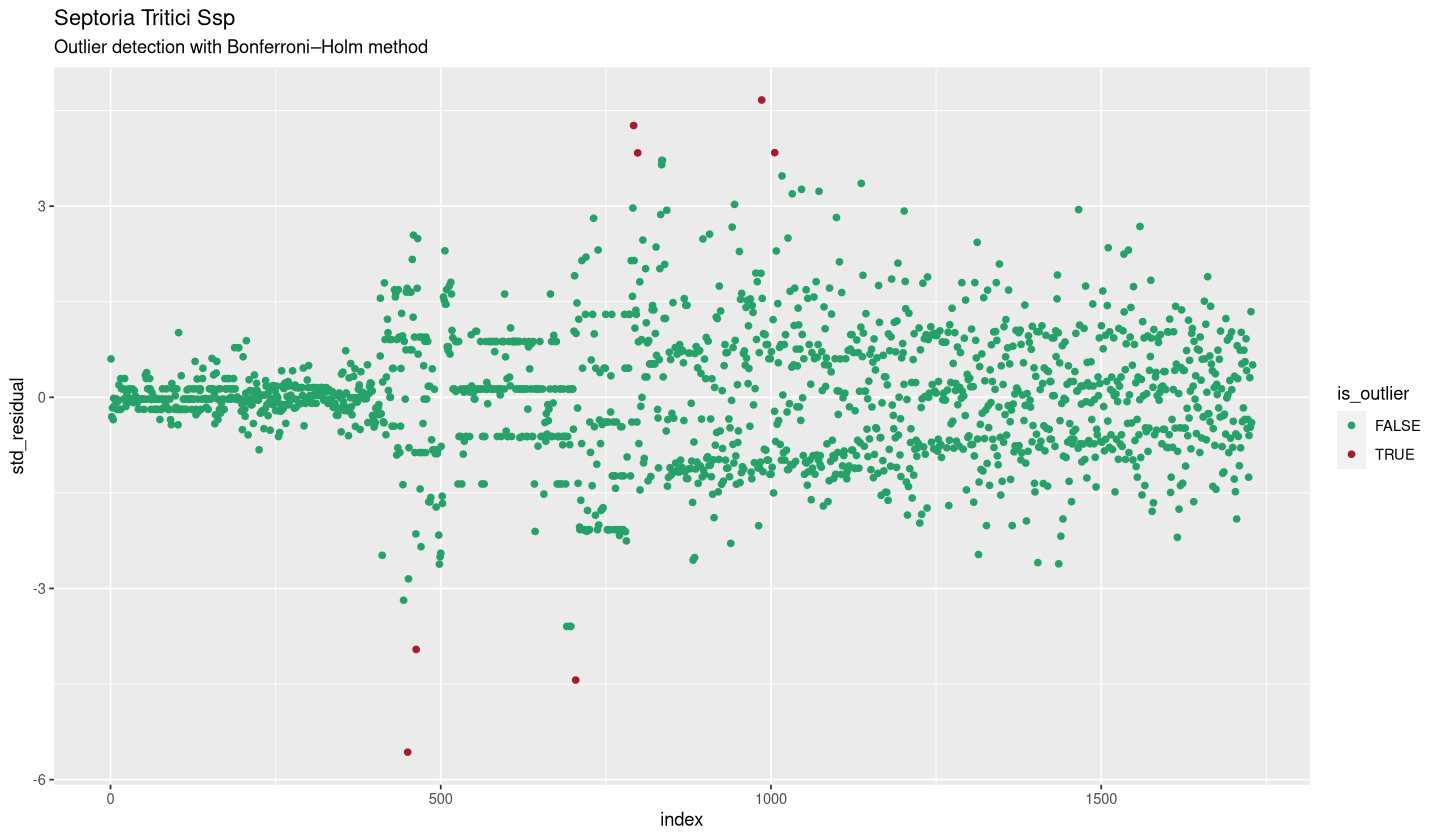

2 outlier value(s) detected for trait Sds Sedimentation Volume

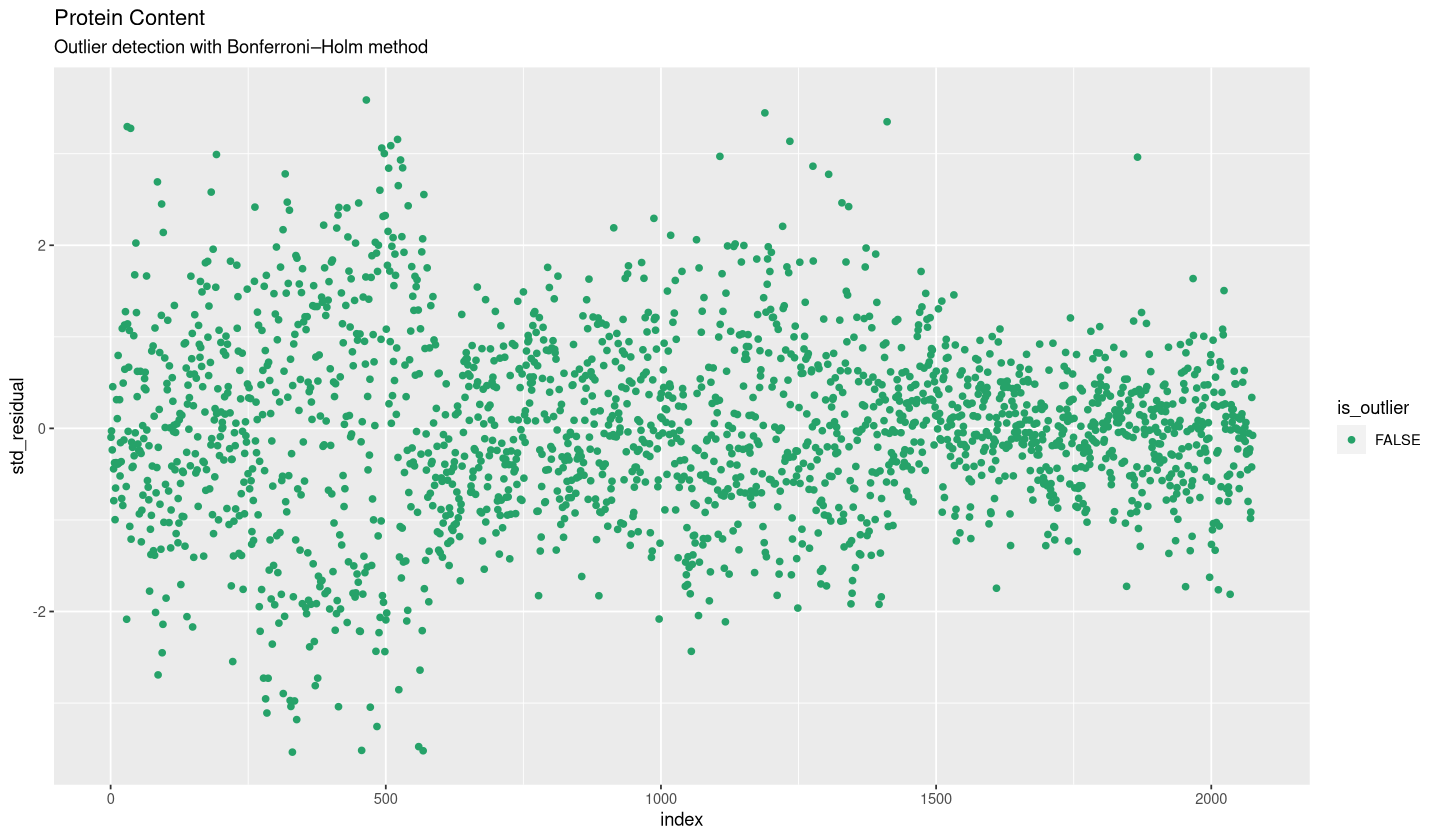

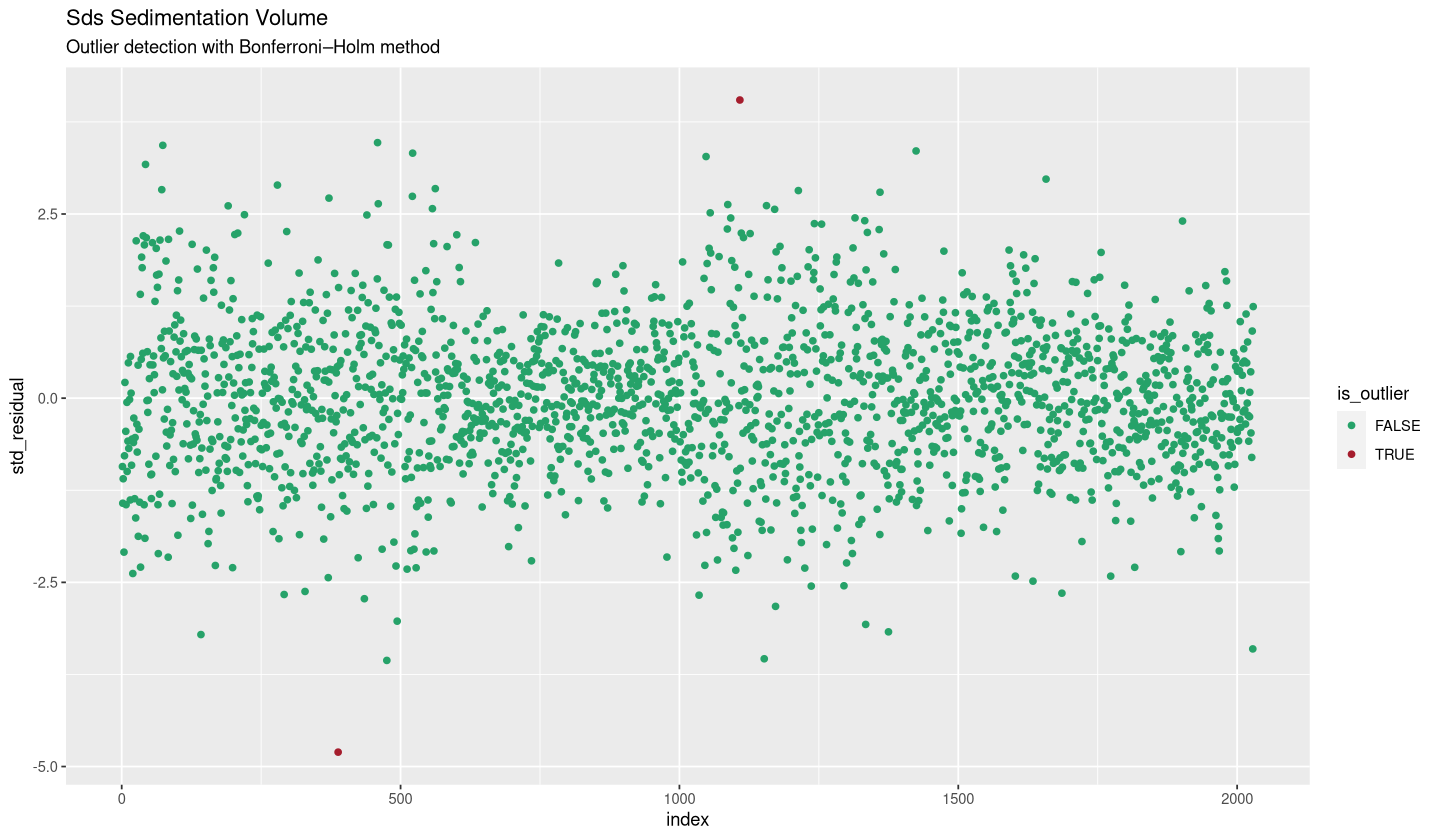

In [27]:
make_BH_multtest <- function(asreml_res){
            trait_title <- colnames(asreml_res$mf)[3] |> str_replace_all("_", " ") |> str_to_title()
            residual <- asreml_res$residuals
            MAD <- 1.4826*median(abs(residual-median(residual))) #approx constant https://en.wikipedia.org/wiki/Median_absolute_deviation#Relation_to_standard_deviation
            rawp_BHStud <- 2 * (1 - pnorm(abs(residual/MAD)))
            test_BHStud <- mt.rawp2adjp(rawp_BHStud, proc=c("Holm"))
            result_df <- tibble(adjp=test_BHStud[[1]][,1], bholm=test_BHStud[[1]][,2], index=test_BHStud[[2]]) |>
                    mutate(is_outlier = bholm < 0.05) |> arrange(index) |> mutate(std_residual = scale(residual)[,1])
            cat(sum(result_df$is_outlier), "outlier value(s) detected for trait", trait_title)
            plot(ggplot(result_df, aes(index,std_residual, color=is_outlier)) + geom_jitter()
                 + scale_colour_manual(values = c("TRUE" = "#A51D2D", "FALSE" = "#26A269"))
                 + labs(title = trait_title, subtitle = "Outlier detection with Bonferroni–Holm method"))
            return(result_df |> as.data.frame())}

result_BH_HT <- make_BH_multtest(asreml_res_HT)
result_BH_PH <- make_BH_multtest(asreml_res_PH)
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)
result_BH_PM <- make_BH_multtest(asreml_res_PM)
result_BH_LR <- make_BH_multtest(asreml_res_LR)
result_BH_ST <- make_BH_multtest(asreml_res_ST)
result_BH_PC <- make_BH_multtest(asreml_res_PC)
result_BH_SV <- make_BH_multtest(asreml_res_SV)

In [28]:
correct_II <- function(data_corrected_I, result_BH){
                        data_corrected_I[result_BH[which(!result_BH$is_outlier),"index"],] |> 
                        group_by(accenumb) |> filter(n() > 1) |> arrange(campaign) |> 
                        as.data.frame() |> droplevels()}

data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)
data_corrected_PM_II <- data_corrected_PM_I |> correct_II(result_BH_PM)
data_corrected_LR_II <- data_corrected_LR_I |> correct_II(result_BH_LR)
data_corrected_ST_II <- data_corrected_ST_I |> correct_II(result_BH_ST)
data_corrected_PC_II <- data_corrected_PC_I |> correct_II(result_BH_PC)
data_corrected_SV_II <- data_corrected_SV_I |> correct_II(result_BH_SV)

## Calculate heritability

In [29]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:05 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -14637.07           1.0   6918 13:39:05    0.0
 2     -13668.09           1.0   6918 13:39:05    0.0
 3     -13093.18           1.0   6918 13:39:05    0.0
 4     -12782.31           1.0   6918 13:39:05    0.0
 5     -12645.40           1.0   6918 13:39:05    0.0
 6     -12621.40           1.0   6918 13:39:05    0.0
 7     -12619.32           1.0   6918 13:39:05    0.0
 8     -12619.16           1.0   6918 13:39:05    0.0
 9     -12619.14           1.0   6918 13:39:05    0.0
10     -12619.14           1.0   6918 13:39:05    0.0


In [30]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:05 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -25838.43           1.0   7527 13:39:05    0.0
 2     -24674.66           1.0   7527 13:39:05    0.0
 3     -23666.34           1.0   7527 13:39:05    0.0
 4     -23191.53           1.0   7527 13:39:05    0.0
 5     -22972.81           1.0   7527 13:39:05    0.0
 6     -22930.31           1.0   7527 13:39:05    0.0
 7     -22926.74           1.0   7527 13:39:05    0.0
 8     -22926.56           1.0   7527 13:39:05    0.0
 9     -22926.55           1.0   7527 13:39:05    0.0
10     -22926.54           1.0   7527 13:39:05    0.0
11     -22926.54           1.0   7527 13:39:05    0.0


In [31]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:05 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -7126.169           1.0   3069 13:39:05    0.0
 2     -6916.133           1.0   3069 13:39:05    0.0
 3     -6697.861           1.0   3069 13:39:05    0.0
 4     -6562.528           1.0   3069 13:39:05    0.0
 5     -6516.103           1.0   3069 13:39:05    0.0
 6     -6510.630           1.0   3069 13:39:05    0.0
 7     -6510.121           1.0   3069 13:39:05    0.0
 8     -6510.076           1.0   3069 13:39:05    0.0
 9     -6510.076           1.0   3069 13:39:05    0.0


In [32]:
asreml_res_h_PM <- asreml(powdery_mildew ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PM_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:05 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2904.967           1.0   2440 13:39:05    0.0 (1 restrained)
 2     -2778.990           1.0   2440 13:39:05    0.0 (1 restrained)
 3     -2649.102           1.0   2440 13:39:05    0.0 (1 restrained)
 4     -2608.499           1.0   2440 13:39:05    0.0 (1 restrained)
 5     -2600.546           1.0   2440 13:39:05    0.0 (1 restrained)
 6     -2600.185           1.0   2440 13:39:05    0.0
 7     -2600.161           1.0   2440 13:39:05    0.0
 8     -2600.160           1.0   2440 13:39:05    0.0


In [33]:
asreml_res_h_LR <- asreml(leaf_rust ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_LR_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:05 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3750.557           1.0   3179 13:39:05    0.0
 2     -3637.256           1.0   3179 13:39:05    0.0
 3     -3534.159           1.0   3179 13:39:05    0.0
 4     -3491.267           1.0   3179 13:39:05    0.0
 5     -3482.677           1.0   3179 13:39:05    0.0
 6     -3481.996           1.0   3179 13:39:05    0.0
 7     -3481.918           1.0   3179 13:39:05    0.0
 8     -3481.916           1.0   3179 13:39:05    0.0


In [34]:
asreml_res_h_ST <- asreml(septoria_tritici_ssp ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_ST_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:06 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1128.873           1.0   1720 13:39:06    0.0
 2     -1021.119           1.0   1720 13:39:06    0.0
 3      -933.625           1.0   1720 13:39:06    0.0
 4      -895.747           1.0   1720 13:39:06    0.0
 5      -885.069           1.0   1720 13:39:06    0.0
 6      -882.932           1.0   1720 13:39:06    0.0
 7      -882.333           1.0   1720 13:39:06    0.0
 8      -882.238           1.0   1720 13:39:06    0.0
 9      -882.233           1.0   1720 13:39:06    0.0


In [35]:
asreml_res_h_PC <- asreml(protein_content ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PC_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:06 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2153.331           1.0   2074 13:39:06    0.0
 2     -2081.198           1.0   2074 13:39:06    0.0
 3     -2009.423           1.0   2074 13:39:06    0.0
 4     -1971.238           1.0   2074 13:39:06    0.0
 5     -1958.963           1.0   2074 13:39:06    0.0
 6     -1957.754           1.0   2074 13:39:06    0.0
 7     -1957.686           1.0   2074 13:39:06    0.0
 8     -1957.684           1.0   2074 13:39:06    0.0


In [36]:
asreml_res_h_SV <- asreml(sds_sedimentation_volume ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SV_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:06 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -5473.852           1.0   2026 13:39:06    0.0
 2     -5339.169           1.0   2026 13:39:06    0.0
 3     -5201.061           1.0   2026 13:39:06    0.0
 4     -5118.570           1.0   2026 13:39:06    0.0
 5     -5082.487           1.0   2026 13:39:06    0.0
 6     -5076.266           1.0   2026 13:39:06    0.0
 7     -5075.913           1.0   2026 13:39:06    0.0
 8     -5075.908           1.0   2026 13:39:06    0.0


In [37]:
get_quality <- function(data_sub, asreml_res_h){
                trait <- colnames(data_sub)[3]
                varcomp <- summary(asreml_res_h)$varcomp
                var_G <- varcomp[2,"component"]
                var_E <- mean(varcomp[3:nrow(varcomp),"component"])
                no_campaigns <- mean(table(data_sub$accenumb[!is.na(data_sub[,trait])]))
                heritability <- var_G/(var_G+(var_E/no_campaigns))
                cat(colnames(data_sub)[3], "heritability:", round(heritability*100,1), "%\n")
                return(tibble(trait, heritability, var_G, var_E, no_campaigns))}

quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_PM <- get_quality(data_sub_PM, asreml_res_h_PM)
quality_LR <- get_quality(data_sub_LR, asreml_res_h_LR)
quality_ST <- get_quality(data_sub_ST, asreml_res_h_ST)
quality_PC <- get_quality(data_sub_PC, asreml_res_h_PC)
quality_SV <- get_quality(data_sub_SV, asreml_res_h_SV)

quality_all = bind_rows(quality_HT, quality_PH, quality_TKW, quality_PM, quality_LR, quality_ST, quality_PC, quality_SV) |> 
                    mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"CREA_wheat_data_quality.csv")

days_to_heading heritability: 90 %
plant_height heritability: 95.2 %
thousand_kernel_weight heritability: 84.8 %
powdery_mildew heritability: 4 %
leaf_rust heritability: 38.6 %
septoria_tritici_ssp heritability: 6.7 %
protein_content heritability: 75.6 %
sds_sedimentation_volume heritability: 91.3 %


## Run linear mixed model with outlier corrected data

In [38]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:06 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -10701.27           1.0   5590 13:39:07    0.8 (4 restrained)
 2     -10070.44           1.0   5590 13:39:07    0.5
 3      -9827.12           1.0   5590 13:39:08    0.5
 4      -9699.10           1.0   5590 13:39:08    0.5
 5      -9655.10           1.0   5590 13:39:09    0.5
 6      -9650.12           1.0   5590 13:39:09    0.5
 7      -9649.55           1.0   5590 13:39:10    0.5
 8      -9649.45           1.0   5590 13:39:10    0.5
 9      -9649.45           1.0   5590 13:39:11    0.5
10      -9649.44           1.0   5590 13:39:11    0.5


In [39]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:11 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -19888.59           1.0   6183 13:39:12    0.8 (4 restrained)
 2     -18509.81           1.0   6183 13:39:13    0.5
 3     -18300.06           1.0   6183 13:39:13    0.5
 4     -18195.20           1.0   6183 13:39:14    0.5
 5     -18161.93           1.0   6183 13:39:14    0.5
 6     -18158.48           1.0   6183 13:39:15    0.5
 7     -18158.23           1.0   6183 13:39:15    0.5
 8     -18158.19           1.0   6183 13:39:16    0.5
 9     -18158.19           1.0   6183 13:39:16    0.5
10     -18158.18           1.0   6183 13:39:17    0.5
11     -18158.18           1.0   6183 13:39:17    0.5


In [40]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:17 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4448.392           1.0   2100 13:39:18    0.3
 2     -4364.425           1.0   2100 13:39:18    0.2
 3     -4323.474           1.0   2100 13:39:18    0.2
 4     -4312.029           1.0   2100 13:39:18    0.2
 5     -4307.258           1.0   2100 13:39:18    0.2
 6     -4305.775           1.0   2100 13:39:19    0.2
 7     -4305.455           1.0   2100 13:39:19    0.2
 8     -4305.428           1.0   2100 13:39:19    0.2
 9     -4305.428           1.0   2100 13:39:19    0.2


In [41]:
asreml_data_PM <- asreml(powdery_mildew ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PM_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:19 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2171.697           1.0   1484 13:39:20    0.3
 2     -2120.615           1.0   1484 13:39:20    0.2
 3     -2071.766           1.0   1484 13:39:20    0.2
 4     -2047.652           1.0   1484 13:39:20    0.2
 5     -2039.955           1.0   1484 13:39:20    0.2
 6     -2038.654           1.0   1484 13:39:21    0.2
 7     -2038.459           1.0   1484 13:39:21    0.2
 8     -2038.440           1.0   1484 13:39:21    0.2
 9     -2038.437           1.0   1484 13:39:21    0.2
10     -2038.437           1.0   1484 13:39:21    0.2


In [42]:
asreml_data_LR <- asreml(leaf_rust ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_LR_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:21 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3068.684           1.0   2197 13:39:22    0.3
 2     -2979.130           1.0   2197 13:39:22    0.2
 3     -2894.360           1.0   2197 13:39:22    0.2
 4     -2854.481           1.0   2197 13:39:22    0.2
 5     -2844.105           1.0   2197 13:39:22    0.2
 6     -2843.246           1.0   2197 13:39:23    0.2
 7     -2843.178           1.0   2197 13:39:23    0.2
 8     -2843.176           1.0   2197 13:39:23    0.2


In [43]:
asreml_data_ST <- asreml(septoria_tritici_ssp ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_ST_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:23 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1237.016           1.0   1238 13:39:23    0.0
 2     -1156.783           1.0   1238 13:39:23    0.0
 3     -1080.073           1.0   1238 13:39:23    0.0
 4     -1043.102           1.0   1238 13:39:23    0.0
 5     -1032.310           1.0   1238 13:39:23    0.0
 6     -1030.187           1.0   1238 13:39:23    0.0
 7     -1029.603           1.0   1238 13:39:23    0.0
 8     -1029.512           1.0   1238 13:39:23    0.0
 9     -1029.509           1.0   1238 13:39:23    0.0


In [44]:
asreml_data_PC <- asreml(protein_content ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PC_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:23 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1840.412           1.0   1803 13:39:23    0.0
 2     -1815.109           1.0   1803 13:39:23    0.0
 3     -1791.337           1.0   1803 13:39:23    0.0
 4     -1780.268           1.0   1803 13:39:23    0.0
 5     -1777.054           1.0   1803 13:39:23    0.0
 6     -1776.588           1.0   1803 13:39:23    0.0
 7     -1776.542           1.0   1803 13:39:23    0.0
 8     -1776.541           1.0   1803 13:39:24    0.0


In [45]:
asreml_data_SV <- asreml(sds_sedimentation_volume ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SV_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Tue Nov 14 13:39:24 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4414.986           1.0   1754 13:39:24    0.0
 2     -4372.852           1.0   1754 13:39:24    0.0
 3     -4355.011           1.0   1754 13:39:24    0.0
 4     -4352.940           1.0   1754 13:39:24    0.0
 5     -4352.723           1.0   1754 13:39:24    0.0
 6     -4352.708           1.0   1754 13:39:24    0.0
 7     -4352.708           1.0   1754 13:39:24    0.0


## Extract BLUEs and create output file

In [46]:
get_BLUEs <- function(asreml_data){
                            trait <- colnames(asreml_data$mf)[3]
                            intercept_index <- nrow(asreml_data$coeff$fixed)
                            intercept <- asreml_data$coeff$fixed[intercept_index]
                            BLUE <- asreml_data$coeff$fixed[-intercept_index,] + intercept
                            return(BLUE |> as.data.frame() |>
                                    rownames_to_column() |>
                                    mutate(genotype=str_split_i(rowname,"_", -1)) |> #assuming there is no underscore in the accession numbers
                                    select(genotype, BLUE) |> rename_with(~paste(trait, .x, sep="_"), 2))}

BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)
BLUEs_PM <- get_BLUEs(asreml_data_PM)
BLUEs_LR <- get_BLUEs(asreml_data_LR)
BLUEs_ST <- get_BLUEs(asreml_data_ST)
BLUEs_PC <- get_BLUEs(asreml_data_PC)
BLUEs_SV <- get_BLUEs(asreml_data_SV)


BLUE_all <- genotypes |> left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        left_join(BLUEs_PM, by="genotype") |>
                        left_join(BLUEs_LR, by="genotype") |> 
                        left_join(BLUEs_ST, by="genotype") |> 
                        left_join(BLUEs_PC, by="genotype") |> 
                        left_join(BLUEs_SV, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"CREA_wheat_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:1473        Min.   :113.8        Min.   : 46.78   
 Class :character   1st Qu.:123.1        1st Qu.: 71.41   
 Mode  :character   Median :125.7        Median : 85.36   
                    Mean   :127.2        Mean   : 89.06   
                    3rd Qu.:131.3        3rd Qu.:104.82   
                    Max.   :149.4        Max.   :142.99   
                    NA's   :144          NA's   :128      
 thousand_kernel_weight_BLUE powdery_mildew_BLUE leaf_rust_BLUE 
 Min.   :22.29               Min.   :-1.56       Min.   :-0.92  
 1st Qu.:36.25               1st Qu.: 1.45       1st Qu.: 1.61  
 Median :40.25               Median : 1.97       Median : 2.30  
 Mean   :40.48               Mean   : 2.20       Mean   : 2.41  
 3rd Qu.:44.45               3rd Qu.: 2.88       3rd Qu.: 3.11  
 Max.   :68.12               Max.   : 8.66       Max.   : 8.29  
 NA's   :503                 NA's   :516         NA's   :490    
 septori

In [47]:
library(rmarkdown)
convert_ipynb("CREA-CI_historic_wheat_data_analysis.ipynb")

In [48]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: FlexiBLAS OPENBLAS-OPENMP;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.25      asreml_4.1.0.154    Matrix_1.6-1.1     
 [4] multtest_2.56.0     Biobase_2.60.0      BiocGenerics_0.46.0
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.0      
[10] dplyr_1.1.3         purrr_1.0.2         readr_